# IMPORTS:

In [ ]:
!pip install dalex -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.6.0-py3-none-any.whl size=1045995 sha256=36c985ea0baf1b8258387260b8f7d50b41c5e22646efff1c793bdbc4f9a06875
  Stored in directory: /root/.cache/pip/wheels/c8/45/19/f5810bf7c5ff9a476ebd89bb5b81a18ffcdf93931d17dbb0c1
Successfully built dalex


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ca4e064d2b9dcc1dd09a5000a0ead6902e6e9d3aa9bcf0547fe816f98c826920
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
#imports necesarios
import pandas as pd
import numpy as np
from sklearn import svm
from scipy.stats import ttest_rel
from sklearn.svm import LinearSVR, NuSVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, RepeatedKFold
from sklearn.inspection import permutation_importance
from scipy.io.arff import loadarff
import statsmodels.api as sm
from sklearn.utils import resample
import dalex as dx
import seaborn as sns

In [ ]:
# Función para evaluar el signo de los valores
def evaluar_valor(valor):
    if valor >= 0:
        return "Positivo"
    else:
        return "Negativo"

In [ ]:
# Crear las columnas del MultiIndex
columns = pd.MultiIndex.from_tuples([
    ('Breakdown', 'Ranking'), ('Breakdown', 'Signo'),
    ('Shapley', 'Ranking'), ('Shapley', 'Signo'),
    ('Lime', 'Ranking'), ('Lime', 'Signo')
])

# Dataset preprocesado:

In [ ]:
#carga del dataset
data=loadarff("/content/drive/MyDrive/TFM/albrecht.arff")
df = pd.DataFrame(data[0])

In [ ]:
df.head(10) #comprobar el dataframe

,Input,Output,Inquiry,File,FPAdj,RawFPcounts,AdjFP,Effort
0,25.0,150.0,75.0,60.0,1.00,1750.00,1750.0,102.4
1,193.0,98.0,70.0,36.0,1.00,1902.00,1902.0,105.2
2,70.0,27.0,0.0,12.0,0.80,535.00,428.0,11.1
3,40.0,60.0,20.0,12.0,1.15,660.00,759.0,21.1
4,10.0,69.0,1.0,9.0,0.90,478.89,431.0,28.8
5,13.0,19.0,0.0,23.0,0.75,377.33,283.0,10.0
6,34.0,14.0,0.0,5.0,0.80,256.25,205.0,8.0
7,17.0,17.0,15.0,5.0,1.10,262.73,289.0,4.9
8,45.0,64.0,14.0,16.0,0.95,715.79,680.0,12.9
9,40.0,60.0,20.0,15.0,1.15,690.43,794.0,19.0


In [ ]:
#comprobar si existen valores null o ?
print("¿Existen valores nulos?:", df.isnull().values.any())
print("¿Existen valores  '?' ?:", (df == '?').values.any())

¿Existen valores nulos?: False
¿Existen valores  '?' ?: False


In [ ]:
print(df.shape)
#obtener nombre de los atributos
print(list(df))
#obtener lista de atributos sin la variable dependiente
feature_names=list(df)
feature_names.remove('Effort')
print(feature_names)

(24, 8)
['Input', 'Output', 'Inquiry', 'File', 'FPAdj', 'RawFPcounts', 'AdjFP', 'Effort']
['Input', 'Output', 'Inquiry', 'File', 'FPAdj', 'RawFPcounts', 'AdjFP']


In [ ]:
df.info() #comprobar el tipo de variables y su cantidad. Parece que no hay ninguna variable objeto

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Input        24 non-null     float64
 1   Output       24 non-null     float64
 2   Inquiry      24 non-null     float64
 3   File         24 non-null     float64
 4   FPAdj        24 non-null     float64
 5   RawFPcounts  24 non-null     float64
 6   AdjFP        24 non-null     float64
 7   Effort       24 non-null     float64
dtypes: float64(8)
memory usage: 1.6 KB


In [ ]:
pd.set_option('display.max_columns', None)
df.describe() #obtener algunas estadísitcas de cada atributo

,Input,Output,Inquiry,File,FPAdj,RawFPcounts,AdjFP,Effort
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,40.250000,47.250000,16.875000,17.375000,0.989583,638.539583,647.625000,21.875000
std,36.913824,35.169466,19.337534,15.522249,0.135116,452.653542,487.995261,28.417895
min,7.000000,12.000000,0.000000,3.000000,0.750000,189.520000,199.000000,0.500000
25%,23.000000,18.500000,3.250000,5.750000,0.887500,347.397500,287.500000,7.150000
50%,33.500000,39.000000,13.500000,11.500000,1.000000,489.105000,506.000000,11.450000
75%,43.500000,64.500000,20.250000,22.250000,1.100000,699.447500,710.250000,19.525000
max,193.000000,150.000000,75.000000,60.000000,1.200000,1902.000000,1902.000000,105.200000


In [ ]:
correlation_matrix=df.corr()
print(correlation_matrix) #coeficientes de correlación

                Input    Output   Inquiry      File     FPAdj  RawFPcounts  \
Input        1.000000  0.437365  0.518808  0.329908  0.104715     0.697841   
Output       0.437365  1.000000  0.678474  0.734455  0.342765     0.898834   
Inquiry      0.518808  0.678474  1.000000  0.578112  0.286527     0.801837   
File         0.329908  0.734455  0.578112  1.000000  0.152240     0.834685   
FPAdj        0.104715  0.342765  0.286527  0.152240  1.000000     0.268481   
RawFPcounts  0.697841  0.898834  0.801837  0.834685  0.268481     1.000000   
AdjFP        0.670758  0.906449  0.776521  0.822755  0.406855     0.985709   
Effort       0.628075  0.876030  0.840994  0.761471  0.234605     0.949967   

                AdjFP    Effort  
Input        0.670758  0.628075  
Output       0.906449  0.876030  
Inquiry      0.776521  0.840994  
File         0.822755  0.761471  
FPAdj        0.406855  0.234605  
RawFPcounts  0.985709  0.949967  
AdjFP        1.000000  0.935014  
Effort       0.935014  1.

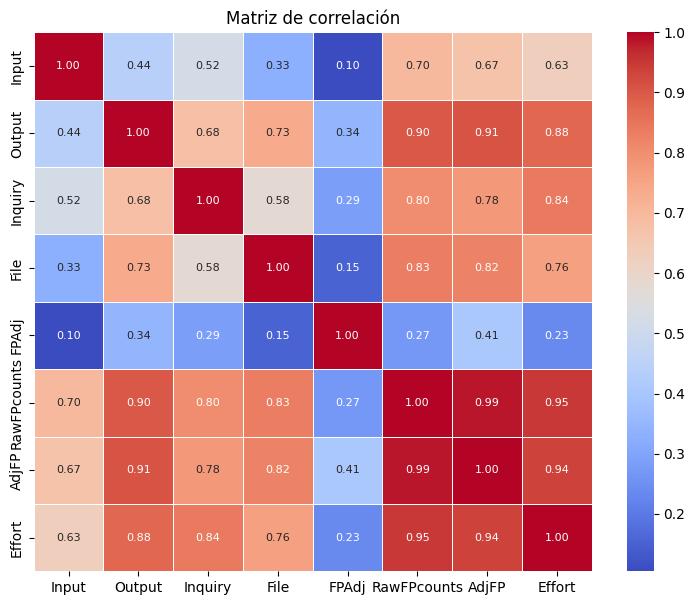

In [ ]:
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()

In [ ]:
# Pares de atributos con correlación superior a 0.95
high_correlation_pairs = []
atributos = []

# Recorre la matriz de correlación y verifica los valores
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            attribute_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_correlation_pairs.append(attribute_pair)

# Imprime los pares de atributos con correlación superior a 0.8 y crear una lista de atributos sin repetir
for pair in high_correlation_pairs:
    print("Correlación alta entre: ", pair[0], "y", pair[1])
    atributos.extend(pair)

# Eliminar duplicados y mantener el orden
atributos = list(dict.fromkeys(atributos))

# Imprimir la lista de atributos
print("Lista de atributos con correlación alta: ", atributos)

Correlación alta entre:  Output y RawFPcounts
Correlación alta entre:  Output y AdjFP
Correlación alta entre:  Output y Effort
Correlación alta entre:  Inquiry y RawFPcounts
Correlación alta entre:  Inquiry y Effort
Correlación alta entre:  File y RawFPcounts
Correlación alta entre:  File y AdjFP
Correlación alta entre:  RawFPcounts y AdjFP
Correlación alta entre:  RawFPcounts y Effort
Correlación alta entre:  AdjFP y Effort
Lista de atributos con correlación alta:  ['Output', 'RawFPcounts', 'AdjFP', 'Effort', 'Inquiry', 'File']


**VALIDACIÓN CRUZADA PARA COMPROBAR EL EFECTO DE LOS PARÁMETROS:**

In [ ]:
# Defino los algoritmos base para evaluar
reg_svr=svm.SVR()
rfr=RandomForestRegressor()
knnr=KNeighborsRegressor()
reg_gbr=GradientBoostingRegressor()
votr=VotingRegressor([('svr',reg_svr),('rf',rfr),('gbr',reg_gbr),('knn',knnr)])
modelos=[reg_svr, rfr, reg_gbr, knnr, votr]

In [ ]:
for i in atributos:
  print("\n##########################################################################################################")
  print("\nPARA EL ATRIBUTO: ", i)
  # Preparando los datos
  x=df[feature_names].values
  y=df['Effort'].values

  alg_escalado = StandardScaler(with_mean=True, with_std=True)
  x_escalado = alg_escalado.fit_transform(x)
  y=y.reshape(-1,1)
  y_escalado = alg_escalado.fit_transform(y)


  # Aumentamos el numero de instancias
  x_augmented, y_augmented = resample(x_escalado, y_escalado, n_samples=len(x)*3, random_state=42)

  df_x_transf = pd.DataFrame(x_augmented, columns=feature_names)
  df_y_transf = pd.DataFrame(y_augmented, columns=['Effort'])
  df_data_transf = pd.concat([df_x_transf, df_y_transf], axis=1)

  X=df_data_transf[feature_names]
  Y=df_data_transf['Effort']

  x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=42)
  x_train_sin=x_train.drop(i, axis=1)

  for j in modelos:
    # Realizar validación cruzada con y sin el atributo con alta correlación:
    # Con el atributo
    cv_scores_con = cross_val_score(j, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Sin el atributo
    cv_scores_sin = cross_val_score(j, x_train_sin, y_train, cv=5, scoring='neg_mean_squared_error')

    # Calcular el estadístico t y el p-valor
    t_statistic, p_value = ttest_rel(cv_scores_con, cv_scores_sin)

    # Mostrar los resultados
    print("-------------------------------------------------------------------------------------------------------------")
    print("El modelo: ", j)
    print("MSE de validación cruzada (con atributo):", cv_scores_con)
    print("MSE de validación cruzada (sin atributo):", cv_scores_sin)
    print("El MSE medio con atributo es: ", np.mean(cv_scores_con), "\nEl MSE medio sin atributo es: ", np.mean(cv_scores_sin))
    if np.mean(cv_scores_con) > np.mean(cv_scores_sin):
      print("El atributo mejora el desempeño del modelo, con una diferencia de: ", np.mean(cv_scores_con)-np.mean(cv_scores_sin))
    else:
      print("El atributo no mejora el desempeño del modelo, con una diferencia de: ", np.mean(cv_scores_con)-np.mean(cv_scores_sin))

    print("Estadístico t:", t_statistic)
    print("p-valor:", p_value)


##########################################################################################################

PARA EL ATRIBUTO:  RawFPcounts
-------------------------------------------------------------------------------------------------------------
El modelo:  SVR()
MSE de validación cruzada (con atributo): [-0.0132386  -0.01858191 -0.18719184 -1.53689149 -0.00641633]
MSE de validación cruzada (sin atributo): [-0.01335385 -0.01971933 -0.19094311 -1.53750533 -0.0058536 ]
El MSE medio con atributo es:  -0.352464032270698 
El MSE medio sin atributo es:  -0.35347504444632205
El atributo mejora el desempeño del modelo, con una diferencia de:  0.0010110121756240487
Estadístico t: 1.3656236102532895
p-valor: 0.24380857346217596
-------------------------------------------------------------------------------------------------------------
El modelo:  RandomForestRegressor()
MSE de validación cruzada (con atributo): [-0.02026033 -0.01484406 -0.03251662 -0.70993181 -0.01373852]
MSE de validación 

In [ ]:
#estos atributos tienen alta correlación, por lo tanto los elimino
feature_names.remove('RawFPcounts')
print(feature_names)

['Input', 'Output', 'Inquiry', 'File', 'FPAdj', 'AdjFP']


In [ ]:
df_final=df
df_final=df_final.drop("RawFPcounts", axis=1)
df_final.describe()

,Input,Output,Inquiry,File,FPAdj,AdjFP,Effort
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,40.250000,47.250000,16.875000,17.375000,0.989583,647.625000,21.875000
std,36.913824,35.169466,19.337534,15.522249,0.135116,487.995261,28.417895
min,7.000000,12.000000,0.000000,3.000000,0.750000,199.000000,0.500000
25%,23.000000,18.500000,3.250000,5.750000,0.887500,287.500000,7.150000
50%,33.500000,39.000000,13.500000,11.500000,1.000000,506.000000,11.450000
75%,43.500000,64.500000,20.250000,22.250000,1.100000,710.250000,19.525000
max,193.000000,150.000000,75.000000,60.000000,1.200000,1902.000000,105.200000


In [ ]:
# Tomar los valores de la variable dependiente (y) y las independientes (x)
x=df[feature_names].values
y=df['Effort'].values

#se realiza una normalización con el objetivo de obtener una distribución de media cero y varianza uno
alg_escalado = StandardScaler(with_mean=True, with_std=True)
x_escalado = alg_escalado.fit_transform(x)
y=y.reshape(-1,1) #es necesario que sea un array 1d
y_escalado = alg_escalado.fit_transform(y)
y_escalado=y_escalado.ravel() #para aplanar y_escalado

# Realiza el aumento de datos utilizando la técnica de remuestreo bootstrap
x_augmented, y_augmented = resample(x_escalado, y_escalado, n_samples=int(len(x)*2), random_state=42) # x_augmented y y_augmented ahora contienen el conjunto de datos aumentado
y_augmented=y_augmented.ravel()


df_x_transf = pd.DataFrame(x_augmented, columns=feature_names)
df_y_transf = pd.DataFrame(y_augmented, columns=['Effort'])
df_data_transf = pd.concat([df_x_transf, df_y_transf], axis=1)

X=df_data_transf[feature_names]
Y=df_data_transf['Effort']

In [ ]:
#dividir en conjunto de entrenamiento y test 70%-30%
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=42)

# Algoritmos:

## **SVR:**

**GRIDSEARCHCV:**

In [ ]:
#Búsqueda combinacion de parámetros usando GridSearchCV
modelo=svm.SVR()
params={'kernel':['linear','poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4],'gamma':['auto','scale',0.1],'C':list(np.arange(0.5,21.5,1.0))}
score={'mae':'neg_mean_absolute_error','mse':'neg_mean_squared_error','R2':'r2'}

# Definir la validación cruzada repetida
cv = RepeatedKFold(n_splits=5, n_repeats=3)

grid=GridSearchCV(modelo,params,cv=cv,scoring='r2',verbose=1)
grid.fit(x_train,y_train)

Fitting 15 folds for each of 1008 candidates, totalling 15120 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=None),
             estimator=SVR(),
             param_grid={'C': [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,
                               10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5,
                               18.5, 19.5, 20.5],
                         'degree': [1, 2, 3, 4],
                         'gamma': ['auto', 'scale', 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='r2', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'C': 3.5, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVR(C=3.5, degree=1, gamma=0.1)
0.5954659753748609


In [ ]:
#definir algoritmo SVR con los mejores parámetros
svr = svm.SVR(C=3.5, degree=1, gamma=0.1)

In [ ]:
#entrenamiento
modelo_svr=svr.fit(x_train,y_train)

In [ ]:
#predicciones
y_pred = modelo_svr.predict(x_test)

**EVALUACIÓN MODELO:**

In [ ]:
#comprobación resultados
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_pred)
desv_pred= np.std(y_pred)
print(f'Desviación Estándar Predicciones: {desv_pred:.2f}')
media_pred= np.mean(y_pred)
print(f'Media Predicciones: {media_pred:.2f}')

      Actual  Predicted
27 -0.362155  -0.262314
40  0.583223   0.663226
26 -0.682074  -0.581962
43 -0.322615  -0.288018
24 -0.656912  -0.557071
37  1.413574   1.313559
12 -0.656912  -0.557071
19  2.995195   2.895440
4  -0.610182  -0.574911
25  2.894547   1.085161
8  -0.768344  -0.668120
3  -0.398101  -0.298123
6  -0.498750  -0.599037
39  0.248926  -0.289003
33 -0.638939  -0.664803
Desviación Estándar Predicciones: 0.99
Media Predicciones: 0.04


In [ ]:
#calcular residuos
residuos = y_test - y_pred
print(residuos)

27   -0.099841
40   -0.080003
26   -0.100112
43   -0.034597
24   -0.099841
37    0.100015
12   -0.099841
19    0.099756
4    -0.035271
25    1.809386
8    -0.100224
3    -0.099979
6     0.100287
39    0.537929
33    0.025864
Name: Effort, dtype: float64


In [ ]:
#calcular métricas para evaluar el rendimiento del algoritmo
mbe=sm.tools.eval_measures.bias(y_test,y_pred)
print(f'Mean Bias Error: {mbe:.4f}')
mdbe=sm.tools.eval_measures.medianbias(y_test,y_pred)
print(f'Median Bias Error: {mdbe:.4f}')
max=sm.tools.eval_measures.maxabs(y_test,y_pred)
print(f'Maximum Absolute Error: {max:.4f}')
iqr=sm.tools.eval_measures.iqr(y_test,y_pred)
print(f'Interquartile Range of Error: {iqr:.4f}')
stde=sm.tools.eval_measures.stde(y_test,y_pred)
print(f'Standard Deviation of Error: {stde:.4f}')
vare=sm.tools.eval_measures.vare(y_test,y_pred)
print(f'Variance of Error: {vare:.4f}')

print("---------------------------------------------------")
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = sm.tools.eval_measures.rmspe(y_test,y_pred)
r2=r2_score(y_test, y_pred)
mape= mean_absolute_percentage_error(y_test, y_pred)*100
print(f'Mean absolute error: {mae:.2f}')
print(f'Median absolute error: {mdae:.2f}')
print(f'Mean absolute percentage error: {mape:.2f} %')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Root mean squared percentage error: {rmspe:.2f} %')
print(f'Coefficient of determination: {r2:.2f}')

print("---------------------------------------------------")
abs_residuos=abs(residuos)
n_residuos=len(residuos)
mre=abs_residuos/y_test
mmre=np.mean(mre)
mdmre=np.median(mre)
print(f'Mean Magnitude of Error: {mmre:.4f}')
print(f'Median Magnitude of Error: {mdmre:.4f}')
count = mre[mre <= 0.25].count()
pred_25 = (count / len(y_pred)) * 100
print(f'Percentage of Relative Error within 25%: {pred_25:.2f} %')

Mean Bias Error: 0.1282
Median Bias Error: -0.0353
Maximum Absolute Error: 1.8094
Interquartile Range of Error: 0.1996
Standard Deviation of Error: 0.4772
Variance of Error: 0.2277
---------------------------------------------------
Mean absolute error: 0.23
Median absolute error: 0.10
Mean absolute percentage error: 30.28 %
Mean squared error: 0.24
Root mean squared error: 0.49
Root mean squared percentage error: 5.98 %
Coefficient of determination: 0.84
---------------------------------------------------
Mean Magnitude of Error: 0.1008
Median Magnitude of Error: -0.1072
Percentage of Relative Error within 25%: 86.67 %


In [ ]:
modelo_svr.score(x_test, y_test)

0.8383706349447728

In [ ]:
modelo_svr.score(x_train, y_train)

0.9846010868817023

**VALIDACIÓN CRUZADA**

In [ ]:
# El número de folds
n_folds = 5

# Inicializar listas para almacenar las puntuaciones de las métricas. Nos centramos en las métricas comunes en la literatura: R2, MAE, MSE/RMSE, MMRE, PRED(25)
r2_scores = []
mae_scores= []
mse_scores = []
rmse_scores = []
mmre_scores = []
pred_25_scores = []

# Crear los objetos KFold
kf = KFold(n_splits=n_folds)

for train_index, test_index in kf.split(df_data_transf):
    # Dividir los datos en entrenamiento y prueba
    train_data = df_data_transf.iloc[train_index]
    test_data = df_data_transf.iloc[test_index]

    X_train = train_data[feature_names]
    Y_train = train_data['Effort']
    X_test = test_data[feature_names]
    Y_test = test_data['Effort']

    # Entrenar el modelo.
    cv_svr= svm.SVR(C=3.5, degree=1, gamma=0.1)
    cv_svr.fit(X_train, Y_train)

    # Realizar las predicciones en el conjunto de prueba
    Y_pred = cv_svr.predict(X_test)

    # Cálculo de residuos
    residuos = Y_test - Y_pred

    # Calcular las métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2=r2_score(Y_test, Y_pred)
    abs_residuos=abs(residuos)
    n_residuos=len(residuos)
    mre=abs_residuos/Y_test
    mmre=np.mean(mre)
    count = mre[mre <= 0.25].count()
    pred_25 = (count / len(Y_pred)) * 100

    # Agregar las puntuaciones a las listas
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mmre_scores.append(mmre)
    pred_25_scores.append(pred_25)

# Calcular la media de las puntuaciones
mean_r2 = np.mean(r2_scores)
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mmre = np.mean(mmre_scores)
mean_pred_25 = np.mean(pred_25_scores)

print(f'CV Mean absolute error: {mean_mae:.2f}')
print(f'CV Mean squared error: {mean_mse:.2f}')
print(f'CV Root mean squared error: {mean_rmse:.2f}')
print(f'CV Coefficient of determination: {mean_r2:.2f}')
print(f'CV Mean Magnitude of Error: {mean_mmre:.4f}')
print(f'CV Percentage of Relative Error within 25%: {mean_pred_25:.2f} %')

CV Mean absolute error: 0.14
CV Mean squared error: 0.08
CV Root mean squared error: 0.21
CV Coefficient of determination: 0.90
CV Mean Magnitude of Error: -0.1653
CV Percentage of Relative Error within 25%: 95.78 %


In [ ]:
cv_results = cross_validate(svr, X, Y, cv=5, scoring=('neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error','r2'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'test_neg_mean_squared_error',
 'test_neg_root_mean_squared_error',
 'test_r2']

In [ ]:
print("Error Absoluto Medio: ", cv_results['test_neg_mean_absolute_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_absolute_error']))
print("Error Cuadrático Medio: " , cv_results['test_neg_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_squared_error']))
print("Raiz Error Cuadrático Medio: ", cv_results['test_neg_root_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_root_mean_squared_error']))
print("Coeficiente de Determinación: ", cv_results['test_r2'], " // Con una media de: ", np.mean(cv_results['test_r2']))

Error Absoluto Medio:  [-0.08617607 -0.07891334 -0.2640512  -0.11883763 -0.14631964]  // Con una media de:  -0.13885957609681848
Error Cuadrático Medio:  [-0.00819619 -0.00704809 -0.30515988 -0.01552598 -0.0435097 ]  // Con una media de:  -0.07588796758223658
Raiz Error Cuadrático Medio:  [-0.09053279 -0.08395291 -0.55241278 -0.12460329 -0.20858978]  // Con una media de:  -0.21201831165793905
Coeficiente de Determinación:  [0.98113451 0.99367132 0.84381635 0.96663643 0.70726987]  // Con una media de:  0.8985056969937599


In [ ]:
score_result={"Modelo":["SVR"],"MAE":[mean_mae], "MSE":[mean_mse], "RMSE":[mean_rmse], "R2":[mean_r2], "MMRE":[abs(mean_mmre)], "PRED(0.25)":[mean_pred_25/100]}
score_result=pd.DataFrame(score_result)

In [ ]:
score_result

,Modelo,MAE,MSE,RMSE,R2,MMRE,PRED(0.25)
0,SVR,0.13886,0.075888,0.212018,0.898506,0.165299,0.957778


## **RandomForest:**

In [ ]:
modelo=RandomForestRegressor(random_state=42)
params={'n_estimators':[100,200,400],'criterion':["squared_error", "absolute_error"],'min_samples_split':[2,3,4,5],'min_samples_leaf':[1,2,3],'bootstrap':[True,False],'max_depth':[None,1,3,5]}
score={'mae':'neg_mean_absolute_error','rmse':'neg_root_mean_squared_error','R2':'r2'}

# Definir la validación cruzada repetida
cv = RepeatedKFold(n_splits=5, n_repeats=3)

grid=GridSearchCV(modelo,params,cv=3,scoring='r2',verbose=1)
grid.fit(x_train,y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 1, 3, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 400]},
             scoring='r2', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
RandomForestRegressor(criterion='absolute_error', n_estimators=400,
                      random_state=42)
0.45160834649318726


In [ ]:
#rf = RandomForestRegressor(bootstrap=False, n_estimators=100, max_depth=None, criterion='squared_error', min_samples_split=2, min_samples_leaf=1, random_state=42)
rf=RandomForestRegressor(criterion='absolute_error', n_estimators=400, random_state=42)

In [ ]:
modelo_rf=rf.fit(x_train,y_train)

In [ ]:
y_pred = modelo_rf.predict(x_test)

**EVALUACIÓN MODELO:**

In [ ]:
#comprobación resultados
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_pred)
desv_pred= np.std(y_pred)
print(f'Desviación Estándar Predicciones: {desv_pred:.2f}')
media_pred= np.mean(y_pred)
print(f'Media Predicciones: {media_pred:.2f}')

      Actual  Predicted
27 -0.362155  -0.164138
40  0.583223   0.596837
26 -0.682074  -0.677478
43 -0.322615  -0.191385
24 -0.656912  -0.644344
37  1.413574   1.256984
12 -0.656912  -0.644344
19  2.995195   2.040345
4  -0.610182  -0.606736
25  2.894547   1.489698
8  -0.768344  -0.718150
3  -0.398101  -0.377253
6  -0.498750  -0.504591
39  0.248926  -0.301258
33 -0.638939  -0.643239
Desviación Estándar Predicciones: 0.87
Media Predicciones: -0.01


In [ ]:
residuos = y_test - y_pred
print(residuos)

27   -0.198017
40   -0.013615
26   -0.004597
43   -0.131230
24   -0.012568
37    0.156589
12   -0.012568
19    0.954850
4    -0.003446
25    1.404848
8    -0.050194
3    -0.020849
6     0.005841
39    0.550184
33    0.004300
Name: Effort, dtype: float64


In [ ]:
#calcular métricas para evaluar el rendimiento del algoritmo
mbe=sm.tools.eval_measures.bias(y_test,y_pred)
print(f'Mean Bias Error: {mbe:.4f}')
mdbe=sm.tools.eval_measures.medianbias(y_test,y_pred)
print(f'Median Bias Error: {mdbe:.4f}')
max=sm.tools.eval_measures.maxabs(y_test,y_pred)
print(f'Maximum Absolute Error: {max:.4f}')
iqr=sm.tools.eval_measures.iqr(y_test,y_pred)
print(f'Interquartile Range of Error: {iqr:.4f}')
stde=sm.tools.eval_measures.stde(y_test,y_pred)
print(f'Standard Deviation of Error: {stde:.4f}')
vare=sm.tools.eval_measures.vare(y_test,y_pred)
print(f'Variance of Error: {vare:.4f}')

print("---------------------------------------------------")
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = sm.tools.eval_measures.rmspe(y_test,y_pred)
r2=r2_score(y_test, y_pred)
mape= mean_absolute_percentage_error(y_test, y_pred)*100
print(f'Mean absolute error: {mae:.2f}')
print(f'Median absolute error: {mdae:.2f}')
print(f'Mean absolute percentage error: {mape:.2f} %')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Root mean squared percentage error: {rmspe:.2f} %')
print(f'Coefficient of determination: {r2:.2f}')

print("---------------------------------------------------")
abs_residuos=abs(residuos)
n_residuos=len(residuos)
mre=abs_residuos/y_test
mmre=np.mean(mre)
mdmre=np.median(mre)
print(f'Mean Magnitude of Error: {mmre:.4f}')
print(f'Median Magnitude of Error: {mdmre:.4f}')
count = mre[mre <= 0.25].count()
pred_25 = (count / len(y_pred)) * 100
print(f'Percentage of Relative Error within 25%: {pred_25:.2f} %')

Mean Bias Error: 0.1753
Median Bias Error: -0.0046
Maximum Absolute Error: 1.4048
Interquartile Range of Error: 0.0195
Standard Deviation of Error: 0.4329
Variance of Error: 0.1874
---------------------------------------------------
Mean absolute error: 0.23
Median absolute error: 0.02
Mean absolute percentage error: 28.59 %
Mean squared error: 0.22
Root mean squared error: 0.47
Root mean squared percentage error: 6.17 %
Coefficient of determination: 0.86
---------------------------------------------------
Mean Magnitude of Error: 0.1339
Median Magnitude of Error: -0.0067
Percentage of Relative Error within 25%: 80.00 %


In [ ]:
modelo_rf.score(x_test, y_test)

0.8555894692553371

In [ ]:
modelo_rf.score(x_train, y_train)

0.939887750083521

**VALIDACIÓN CRUZADA:**

In [ ]:
# El número de folds
n_folds = 5

# Inicializar listas para almacenar las puntuaciones de las métricas. Nos centramos en las métricas comunes en la literatura: R2, MAE, MSE/RMSE, MMRE, PRED(25)
r2_scores = []
mae_scores= []
mse_scores = []
rmse_scores = []
mmre_scores = []
pred_25_scores = []

# Crear los objetos KFold
kf = KFold(n_splits=n_folds)

for train_index, test_index in kf.split(df_data_transf):
    # Dividir los datos en entrenamiento y prueba
    train_data = df_data_transf.iloc[train_index]
    test_data = df_data_transf.iloc[test_index]

    X_train = train_data[feature_names]
    Y_train = train_data['Effort']
    X_test = test_data[feature_names]
    Y_test = test_data['Effort']

    # Entrenar el modelo.
    cv_rf=RandomForestRegressor(criterion='absolute_error', n_estimators=400, random_state=42)
    cv_rf.fit(X_train, Y_train)

    # Realizar las predicciones en el conjunto de prueba
    Y_pred = cv_rf.predict(X_test)

    # Cálculo de residuos
    residuos = Y_test - Y_pred

    # Calcular las métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2=r2_score(Y_test, Y_pred)
    abs_residuos=abs(residuos)
    n_residuos=len(residuos)
    mre=abs_residuos/Y_test
    mmre=np.mean(mre)
    count = mre[mre <= 0.25].count()
    pred_25 = (count / len(Y_pred)) * 100

    # Agregar las puntuaciones a las listas
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mmre_scores.append(mmre)
    pred_25_scores.append(pred_25)

# Calcular la media de las puntuaciones
mean_r2 = np.mean(r2_scores)
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mmre = np.mean(mmre_scores)
mean_pred_25 = np.mean(pred_25_scores)

print(f'CV Mean absolute error: {mean_mae:.2f}')
print(f'CV Mean squared error: {mean_mse:.2f}')
print(f'CV Root mean squared error: {mean_rmse:.2f}')
print(f'CV Coefficient of determination: {mean_r2:.2f}')
print(f'CV Mean Magnitude of Error: {mean_mmre:.4f}')
print(f'CV Percentage of Relative Error within 25%: {mean_pred_25:.2f} %')

CV Mean absolute error: 0.13
CV Mean squared error: 0.07
CV Root mean squared error: 0.22
CV Coefficient of determination: 0.86
CV Mean Magnitude of Error: -0.1140
CV Percentage of Relative Error within 25%: 93.78 %


In [ ]:
cv_results = cross_validate(rf, X, Y, cv=5, scoring=('neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error','r2'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'test_neg_mean_squared_error',
 'test_neg_root_mean_squared_error',
 'test_r2']

In [ ]:
print("Error Absoluto Medio: ", cv_results['test_neg_mean_absolute_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_absolute_error']))
print("Error Cuadrático Medio: " , cv_results['test_neg_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_squared_error']))
print("Raiz Error Cuadrático Medio: ", cv_results['test_neg_root_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_root_mean_squared_error']))
print("Coeficiente de Determinación: ", cv_results['test_r2'], " // Con una media de: ", np.mean(cv_results['test_r2']))

Error Absoluto Medio:  [-0.02466341 -0.0944821  -0.2697437  -0.07920737 -0.15721405]  // Con una media de:  -0.1250621235701656
Error Cuadrático Medio:  [-0.00155592 -0.04365406 -0.23230956 -0.01340724 -0.07407261]  // Con una media de:  -0.07299987663558619
Raiz Error Cuadrático Medio:  [-0.0394451  -0.20893553 -0.48198502 -0.11578963 -0.27216284]  // Con una media de:  -0.22366362470922158
Coeficiente de Determinación:  [0.99641869 0.96080181 0.88110182 0.97118936 0.50164477]  // Con una media de:  0.8622312892896001


In [ ]:
score_result=score_result.append({"Modelo":"RandomForest","MAE":mean_mae, "MSE":mean_mse, "RMSE":mean_rmse, "R2":mean_r2, "MMRE":abs(mean_mmre), "PRED(0.25)":mean_pred_25/100}, ignore_index=True)

<ipython-input-36-06667e9c6bdf>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_result=score_result.append({"Modelo":"RandomForest","MAE":mean_mae, "MSE":mean_mse, "RMSE":mean_rmse, "R2":mean_r2, "MMRE":abs(mean_mmre), "PRED(0.25)":mean_pred_25/100}, ignore_index=True)


## **GradientBoostingRegresor:**

In [ ]:
#Búsqueda combinacion de parámetros usando GridSearchCV
modelo=GradientBoostingRegressor(random_state=42)
params={'loss':['squared_error', 'absolute_error'],'learning_rate':[0.1,0.3,0.5],'n_estimators':[100,300,500],'criterion':['friedman_mse','squared_error'],'min_samples_split':[2,3,4],'min_samples_leaf':[1,3,5],'max_depth':[None,1,3]}
score={'mae':'neg_mean_absolute_error','mse':'neg_mean_squared_error','R2':'r2'}

# Definir la validación cruzada repetida
cv = RepeatedKFold(n_splits=3, n_repeats=3)

grid=GridSearchCV(modelo,params,cv=3,scoring='r2',verbose=1)
grid.fit(x_train,y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 0.3, 0.5],
                         'loss': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 1, 3],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             scoring='r2', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoostingRegressor(learning_rate=0.5, max_depth=1, random_state=42)
0.5727333058519334


In [ ]:
gbr=GradientBoostingRegressor(learning_rate=0.5, max_depth=1, random_state=42)

In [ ]:
modelo_gbr=gbr.fit(x_train,y_train)

In [ ]:
y_pred = modelo_gbr.predict(x_test)

**EVALUACIÓN MODELO:**

In [ ]:
#comprobación resultados
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_pred)
desv_pred= np.std(y_pred)
print(f'Desviación Estándar Predicciones: {desv_pred:.2f}')
media_pred= np.mean(y_pred)
print(f'Media Predicciones: {media_pred:.2f}')

      Actual  Predicted
27 -0.362155  -0.323694
40  0.583223   0.575466
26 -0.682074  -0.666309
43 -0.322615  -0.284567
24 -0.656912  -0.649981
37  1.413574   1.418593
12 -0.656912  -0.649981
19  2.995195   2.982604
4  -0.610182  -0.610322
25  2.894547   2.395066
8  -0.768344  -0.757852
3  -0.398101  -0.378539
6  -0.498750  -0.511500
39  0.248926  -0.354819
33 -0.638939  -0.639266
Desviación Estándar Predicciones: 1.16
Media Predicciones: 0.10


In [ ]:
residuos = y_test - y_pred
print(residuos)

27   -0.038462
40    0.007757
26   -0.015766
43   -0.038047
24   -0.006931
37   -0.005019
12   -0.006931
19    0.012592
4     0.000140
25    0.499480
8    -0.010493
3    -0.019562
6     0.012750
39    0.603745
33    0.000327
Name: Effort, dtype: float64


In [ ]:
#calcular métricas para evaluar el rendimiento del algoritmo
mbe=sm.tools.eval_measures.bias(y_test,y_pred)
print(f'Mean Bias Error: {mbe:.4f}')
mdbe=sm.tools.eval_measures.medianbias(y_test,y_pred)
print(f'Median Bias Error: {mdbe:.4f}')
max=sm.tools.eval_measures.maxabs(y_test,y_pred)
print(f'Maximum Absolute Error: {max:.4f}')
iqr=sm.tools.eval_measures.iqr(y_test,y_pred)
print(f'Interquartile Range of Error: {iqr:.4f}')
stde=sm.tools.eval_measures.stde(y_test,y_pred)
print(f'Standard Deviation of Error: {stde:.4f}')
vare=sm.tools.eval_measures.vare(y_test,y_pred)
print(f'Variance of Error: {vare:.4f}')

print("---------------------------------------------------")
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = sm.tools.eval_measures.rmspe(y_test,y_pred)
r2=r2_score(y_test, y_pred)
mape= mean_absolute_percentage_error(y_test, y_pred)*100
print(f'Mean absolute error: {mae:.2f}')
print(f'Median absolute error: {mdae:.2f}')
print(f'Mean absolute percentage error: {mape:.2f} %')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Root mean squared percentage error: {rmspe:.2f} %')
print(f'Coefficient of determination: {r2:.2f}')

print("---------------------------------------------------")
abs_residuos=abs(residuos)
n_residuos=len(residuos)
mre=abs_residuos/y_test
mmre=np.mean(mre)
mdmre=np.median(mre)
print(f'Mean Magnitude of Error: {mmre:.4f}')
print(f'Median Magnitude of Error: {mdmre:.4f}')
count = mre[mre <= 0.25].count()
pred_25 = (count / len(y_pred)) * 100
print(f'Percentage of Relative Error within 25%: {pred_25:.2f} %')

Mean Bias Error: 0.0664
Median Bias Error: -0.0050
Maximum Absolute Error: 0.6037
Interquartile Range of Error: 0.0183
Standard Deviation of Error: 0.1918
Variance of Error: 0.0368
---------------------------------------------------
Mean absolute error: 0.09
Median absolute error: 0.01
Mean absolute percentage error: 19.84 %
Mean squared error: 0.04
Root mean squared error: 0.20
Root mean squared percentage error: 6.29 %
Coefficient of determination: 0.97
---------------------------------------------------
Mean Magnitude of Error: 0.1508
Median Magnitude of Error: -0.0106
Percentage of Relative Error within 25%: 93.33 %


In [ ]:
modelo_gbr.score(x_test, y_test)

0.9727218317115404

In [ ]:
modelo_gbr.score(x_train, y_train)

0.9991747150257034

**VALIDACIÓN CRUZADA:**

In [ ]:
# El número de folds
n_folds = 5

# Inicializar listas para almacenar las puntuaciones de las métricas. Nos centramos en las métricas comunes en la literatura: R2, MAE, MSE/RMSE, MMRE, PRED(25)
r2_scores = []
mae_scores= []
mse_scores = []
rmse_scores = []
mmre_scores = []
pred_25_scores = []

# Crear los objetos KFold
kf = KFold(n_splits=n_folds)

for train_index, test_index in kf.split(df_data_transf):
    # Dividir los datos en entrenamiento y prueba
    train_data = df_data_transf.iloc[train_index]
    test_data = df_data_transf.iloc[test_index]

    X_train = train_data[feature_names]
    Y_train = train_data['Effort']
    X_test = test_data[feature_names]
    Y_test = test_data['Effort']

    # Entrenar el modelo.
    cv_gbr=GradientBoostingRegressor(learning_rate=0.5, max_depth=1, random_state=42)
    cv_gbr.fit(X_train, Y_train)

    # Realizar las predicciones en el conjunto de prueba
    Y_pred = cv_gbr.predict(X_test)

    # Cálculo de residuos
    residuos = Y_test - Y_pred

    # Calcular las métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2=r2_score(Y_test, Y_pred)
    abs_residuos=abs(residuos)
    n_residuos=len(residuos)
    mre=abs_residuos/Y_test
    mmre=np.mean(mre)
    count = mre[mre <= 0.25].count()
    pred_25 = (count / len(Y_pred)) * 100

    # Agregar las puntuaciones a las listas
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mmre_scores.append(mmre)
    pred_25_scores.append(pred_25)

# Calcular la media de las puntuaciones
mean_r2 = np.mean(r2_scores)
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mmre = np.mean(mmre_scores)
mean_pred_25 = np.mean(pred_25_scores)

print(f'CV Mean absolute error: {mean_mae:.2f}')
print(f'CV Mean squared error: {mean_mse:.2f}')
print(f'CV Root mean squared error: {mean_rmse:.2f}')
print(f'CV Coefficient of determination: {mean_r2:.2f}')
print(f'CV Mean Magnitude of Error: {mean_mmre:.4f}')
print(f'CV Percentage of Relative Error within 25%: {mean_pred_25:.2f} %')

CV Mean absolute error: 0.07
CV Mean squared error: 0.05
CV Root mean squared error: 0.16
CV Coefficient of determination: 0.89
CV Mean Magnitude of Error: -0.0579
CV Percentage of Relative Error within 25%: 95.78 %


In [ ]:
cv_results = cross_validate(gbr, X, Y, cv=5, scoring=('neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error','r2'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'test_neg_mean_squared_error',
 'test_neg_root_mean_squared_error',
 'test_r2']

In [ ]:
print("Error Absoluto Medio: ", cv_results['test_neg_mean_absolute_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_absolute_error']))
print("Error Cuadrático Medio: " , cv_results['test_neg_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_squared_error']))
print("Raiz Error Cuadrático Medio: ", cv_results['test_neg_root_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_root_mean_squared_error']))
print("Coeficiente de Determinación: ", cv_results['test_r2'], " // Con una media de: ", np.mean(cv_results['test_r2']))

Error Absoluto Medio:  [-0.01873894 -0.01460004 -0.15630362 -0.04530784 -0.12720926]  // Con una media de:  -0.07243193869318054
Error Cuadrático Medio:  [-0.00043398 -0.00048926 -0.15705089 -0.00994698 -0.06723827]  // Con una media de:  -0.04703187450703557
Raiz Error Cuadrático Medio:  [-0.02083212 -0.02211912 -0.39629647 -0.09973452 -0.25930344]  // Con una media de:  -0.1596571338180711
Coeficiente de Determinación:  [0.9990011  0.99956068 0.9196199  0.97862508 0.54762572]  // Con una media de:  0.8888864959213093


In [ ]:
score_result=score_result.append({"Modelo":"GradientBoosting","MAE":mean_mae, "MSE":mean_mse, "RMSE":mean_rmse, "R2":mean_r2, "MMRE":abs(mean_mmre), "PRED(0.25)":mean_pred_25/100}, ignore_index=True)

<ipython-input-46-0f69b13d04a5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_result=score_result.append({"Modelo":"GradientBoosting","MAE":mean_mae, "MSE":mean_mse, "RMSE":mean_rmse, "R2":mean_r2, "MMRE":abs(mean_mmre), "PRED(0.25)":mean_pred_25/100}, ignore_index=True)


## **Voting:**

In [ ]:
reg_vot=VotingRegressor(estimators=[('rf',rf),('SVR',svr),('gbr',gbr)])

In [ ]:
modelo_voting=reg_vot.fit(x_train,y_train)

In [ ]:
y_pred = modelo_voting.predict(x_test)

**EVALUACIÓN MODELO:**

In [ ]:
#comprobación resultados
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_pred)
desv_pred= np.std(y_pred)
print(f'Desviación Estándar Predicciones: {desv_pred:.2f}')
media_pred= np.mean(y_pred)
print(f'Media Predicciones: {media_pred:.2f}')

      Actual  Predicted
27 -0.362155  -0.250049
40  0.583223   0.611843
26 -0.682074  -0.641916
43 -0.322615  -0.254657
24 -0.656912  -0.617132
37  1.413574   1.329712
12 -0.656912  -0.617132
19  2.995195   2.639463
4  -0.610182  -0.597323
25  2.894547   1.656642
8  -0.768344  -0.714707
3  -0.398101  -0.351305
6  -0.498750  -0.538376
39  0.248926  -0.315027
33 -0.638939  -0.649102
Desviación Estándar Predicciones: 1.00
Media Predicciones: 0.05


In [ ]:
residuos = y_test - y_pred
print(residuos)

27   -0.112107
40   -0.028620
26   -0.040158
43   -0.067958
24   -0.039780
37    0.083862
12   -0.039780
19    0.355732
4    -0.012859
25    1.237905
8    -0.053637
3    -0.046796
6     0.039626
39    0.563952
33    0.010163
Name: Effort, dtype: float64


In [ ]:
#calcular métricas para evaluar el rendimiento del algoritmo
mbe=sm.tools.eval_measures.bias(y_test,y_pred)
print(f'Mean Bias Error: {mbe:.4f}')
mdbe=sm.tools.eval_measures.medianbias(y_test,y_pred)
print(f'Median Bias Error: {mdbe:.4f}')
max=sm.tools.eval_measures.maxabs(y_test,y_pred)
print(f'Maximum Absolute Error: {max:.4f}')
iqr=sm.tools.eval_measures.iqr(y_test,y_pred)
print(f'Interquartile Range of Error: {iqr:.4f}')
stde=sm.tools.eval_measures.stde(y_test,y_pred)
print(f'Standard Deviation of Error: {stde:.4f}')
vare=sm.tools.eval_measures.vare(y_test,y_pred)
print(f'Variance of Error: {vare:.4f}')

print("---------------------------------------------------")
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = sm.tools.eval_measures.rmspe(y_test,y_pred)
r2=r2_score(y_test, y_pred)
mape= mean_absolute_percentage_error(y_test, y_pred)*100
print(f'Mean absolute error: {mae:.2f}')
print(f'Median absolute error: {mdae:.2f}')
print(f'Mean absolute percentage error: {mape:.2f} %')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Root mean squared percentage error: {rmspe:.2f} %')
print(f'Coefficient of determination: {r2:.2f}')

print("---------------------------------------------------")
abs_residuos=abs(residuos)
n_residuos=len(residuos)
mre=abs_residuos/y_test
mmre=np.mean(mre)
mdmre=np.median(mre)
print(f'Mean Magnitude of Error: {mmre:.4f}')
print(f'Median Magnitude of Error: {mdmre:.4f}')
count = mre[mre <= 0.25].count()
pred_25 = (count / len(y_pred)) * 100
print(f'Percentage of Relative Error within 25%: {pred_25:.2f} %')

Mean Bias Error: 0.1233
Median Bias Error: -0.0286
Maximum Absolute Error: 1.2379
Interquartile Range of Error: 0.0798
Standard Deviation of Error: 0.3450
Variance of Error: 0.1190
---------------------------------------------------
Mean absolute error: 0.18
Median absolute error: 0.05
Mean absolute percentage error: 26.16 %
Mean squared error: 0.13
Root mean squared error: 0.37
Root mean squared percentage error: 6.06 %
Coefficient of determination: 0.91
---------------------------------------------------
Mean Magnitude of Error: 0.1278
Median Magnitude of Error: -0.0589
Percentage of Relative Error within 25%: 86.67 %


In [ ]:
modelo_voting.score(x_test, y_test)

0.9111385405093841

In [ ]:
modelo_voting.score(x_train, y_train)

0.9882355962648154

**VALIDACIÓN CRUZADA:**

In [ ]:
# El número de folds
n_folds = 5

# Inicializar listas para almacenar las puntuaciones de las métricas. Nos centramos en las métricas comunes en la literatura: R2, MAE, MSE/RMSE, MMRE, PRED(25)
r2_scores = []
mae_scores= []
mse_scores = []
rmse_scores = []
mmre_scores = []
pred_25_scores = []

# Crear los objetos KFold
kf = KFold(n_splits=n_folds)

for train_index, test_index in kf.split(df_data_transf):
    # Dividir los datos en entrenamiento y prueba
    train_data = df_data_transf.iloc[train_index]
    test_data = df_data_transf.iloc[test_index]

    X_train = train_data[feature_names]
    Y_train = train_data['Effort']
    X_test = test_data[feature_names]
    Y_test = test_data['Effort']

    # Entrenar el modelo.
    cv_vot=VotingRegressor(estimators=[('rf',rf),('SVR',svr),('gbr',gbr)])
    cv_vot.fit(X_train, Y_train)

    # Realizar las predicciones en el conjunto de prueba
    Y_pred = cv_vot.predict(X_test)

    # Cálculo de residuos
    residuos = Y_test - Y_pred

    # Calcular las métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2=r2_score(Y_test, Y_pred)
    abs_residuos=abs(residuos)
    n_residuos=len(residuos)
    mre=abs_residuos/Y_test
    mmre=np.mean(mre)
    count = np.sum(mre <= 0.25)
    pred_25 = (count / len(Y_pred)) * 100

    # Agregar las puntuaciones a las listas
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mmre_scores.append(mmre)
    pred_25_scores.append(pred_25)

# Calcular la media de las puntuaciones
mean_r2 = np.mean(r2_scores)
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mmre = np.mean(mmre_scores)
mean_pred_25 = np.mean(pred_25_scores)

print(f'CV Mean absolute error: {mean_mae:.2f}')
print(f'CV Mean squared error: {mean_mse:.2f}')
print(f'CV Root mean squared error: {mean_rmse:.2f}')
print(f'CV Coefficient of determination: {mean_r2:.2f}')
print(f'CV Mean Magnitude of Error: {mean_mmre:.4f}')
print(f'CV Percentage of Relative Error within 25%: {mean_pred_25:.2f} %')

CV Mean absolute error: 0.10
CV Mean squared error: 0.06
CV Root mean squared error: 0.19
CV Coefficient of determination: 0.90
CV Mean Magnitude of Error: -0.0928
CV Percentage of Relative Error within 25%: 95.78 %


In [ ]:
cv_results = cross_validate(reg_vot, X, Y, cv=5, scoring=('neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error','r2'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'test_neg_mean_squared_error',
 'test_neg_root_mean_squared_error',
 'test_r2']

In [ ]:
print("Error Absoluto Medio: ", cv_results['test_neg_mean_absolute_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_absolute_error']))
print("Error Cuadrático Medio: " , cv_results['test_neg_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_mean_squared_error']))
print("Raiz Error Cuadrático Medio: ", cv_results['test_neg_root_mean_squared_error'], " // Con una media de: ", np.mean(cv_results['test_neg_root_mean_squared_error']))
print("Coeficiente de Determinación: ", cv_results['test_r2'], " // Con una media de: ", np.mean(cv_results['test_r2']))

Error Absoluto Medio:  [-0.03469285 -0.06094688 -0.22293954 -0.06413831 -0.13767747]  // Con una media de:  -0.1040790085168053
Error Cuadrático Medio:  [-0.0015262  -0.00842095 -0.21082721 -0.00937325 -0.05723736]  // Con una media de:  -0.05747699428904061
Raiz Error Cuadrático Medio:  [-0.03906666 -0.09176573 -0.45915924 -0.09681557 -0.2392433 ]  // Con una media de:  -0.18521010002384175
Coeficiente de Determinación:  [0.99648708 0.9924386  0.89209668 0.97985794 0.61491116]  // Con una media de:  0.895158290601443


In [ ]:
score_result=score_result.append({"Modelo":"Voting","MAE":mean_mae, "MSE":mean_mse, "RMSE":mean_rmse, "R2":mean_r2, "MMRE":abs(mean_mmre), "PRED(0.25)":mean_pred_25/100}, ignore_index=True)

<ipython-input-56-c16958f5272a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_result=score_result.append({"Modelo":"Voting","MAE":mean_mae, "MSE":mean_mse, "RMSE":mean_rmse, "R2":mean_r2, "MMRE":abs(mean_mmre), "PRED(0.25)":mean_pred_25/100}, ignore_index=True)


# **Explicabilidad:**

In [ ]:
# Crear las columnas del MultiIndex
columns_multi = pd.MultiIndex.from_tuples([
    ('Breakdown', 'Ranking'), ('Breakdown', 'Signo'),
    ('Shapley', 'Ranking'), ('Shapley', 'Signo'),
    ('Lime', 'Ranking'), ('Lime', 'Signo')
])

## **SVR:**

**FEATURE IMPORTANCE:**

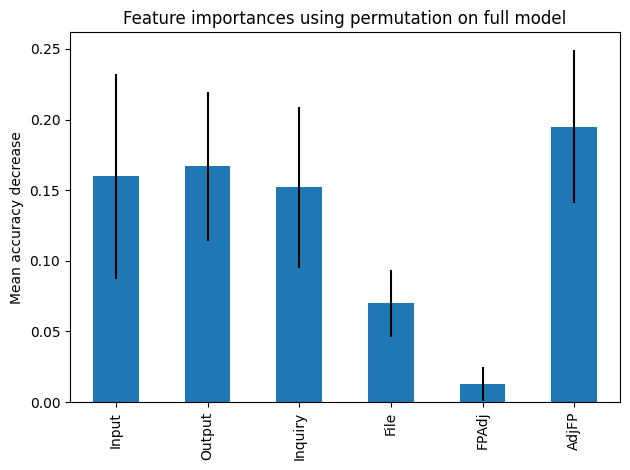

In [ ]:
# Uso de permutation importance
permu = permutation_importance(modelo_svr, x_test, y_test, n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=feature_names)[permu.importances_mean.round(3) > 0.000]
fig, ax = plt.subplots()
permu_importances.plot.bar(yerr=permu.importances_std[permu.importances_mean.round(3) > 0.000], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

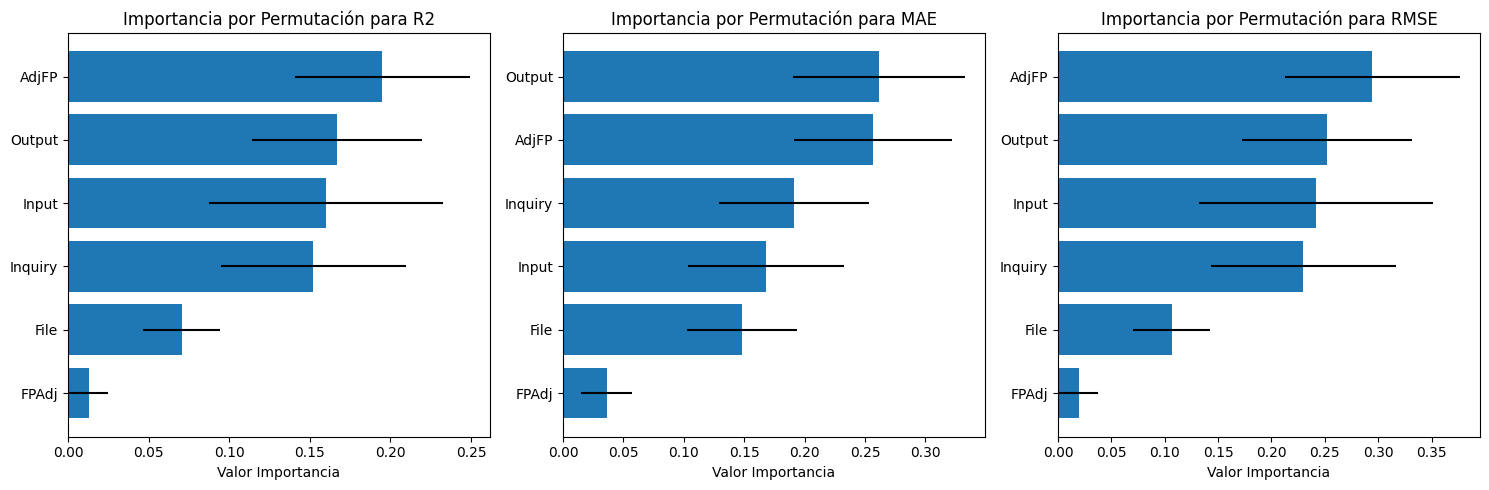

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
metric_names = ['R2', 'MAE', 'RMSE']

permu_score = permutation_importance(modelo_svr, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Itera a través de las métricas
for i, metric in enumerate(scoring):
    permu = permu_score[metric]

    # Filtra las características que cumplen la condición
    filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
    sorted_feature_names = [feature_names[j] for j in filtered_indices]
    importances_mean = permu.importances_mean[filtered_indices]
    importances_std = permu.importances_std[filtered_indices]

    # Ordena los datos por importancia de mayor a menor
    sorted_indices = np.argsort(importances_mean)[::1]
    sorted_feature_names = [sorted_feature_names[j] for j in sorted_indices]
    importances_mean = importances_mean[sorted_indices]
    importances_std = importances_std[sorted_indices]

    # Crea la representación gráfica en el subplot correspondiente
    axs[i].barh(range(len(sorted_feature_names)), importances_mean, xerr=importances_std, align='center')
    axs[i].set_yticks(range(len(sorted_feature_names)))
    axs[i].set_yticklabels(sorted_feature_names)
    axs[i].set_xlabel('Valor Importancia')
    axs[i].set_title(f'Importancia por Permutación para {metric_names[i]}')

# Ajusta los espacios entre subplots y muestra la figura
plt.tight_layout()
plt.show()

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

# Crea un diccionario para almacenar los DataFrames
results_global_svr = {}

permu_score = permutation_importance(modelo_svr, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
for i, metric in enumerate(scoring):
  permu = permu_score[metric]

  # Filtra las características que cumplen la condición
  filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
  sorted_feature_names = [feature_names[j] for j in filtered_indices]
  importances_mean = permu.importances_mean[filtered_indices]
  importances_std = permu.importances_std[filtered_indices]



  # Crear un DataFrame con los resultados
  df_exp_global = pd.DataFrame({'Feature': sorted_feature_names,
                       'Importance_Mean': importances_mean,
                       'Importance_Std': importances_std})

  # Ordenar el DataFrame por importance_mean en orden descendente
  df_exp_global = df_exp_global.sort_values(by='Importance_Mean', ascending=False)

  # Asignar el DataFrame al diccionario con el nombre de la métrica
  results_global_svr[f'df_global_{metric_names[i]}'] = df_exp_global

In [ ]:
results_global_svr['df_global_R2']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.194979,0.054259
1,Output,0.166856,0.052830
0,Input,0.159937,0.072563
2,Inquiry,0.152224,0.057169
3,File,0.070413,0.023637
4,FPAdj,0.012867,0.012003


In [ ]:
results_global_svr['df_global_MAE']

,Feature,Importance_Mean,Importance_Std
1,Output,0.261562,0.071102
5,AdjFP,0.256336,0.065302
2,Inquiry,0.191223,0.062123
0,Input,0.168059,0.064340
3,File,0.148068,0.045811
4,FPAdj,0.036105,0.021012


In [ ]:
results_global_svr['df_global_RMSE']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.294566,0.081972
1,Output,0.252078,0.079814
0,Input,0.241626,0.109625
2,Inquiry,0.229974,0.086368
3,File,0.106377,0.035710
4,FPAdj,0.019439,0.018134


**BREAK-DOWN, SHAP Y LIME:**

In [ ]:
#primero definimos el explainer
exp = dx.Explainer(modelo_svr, x_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 33 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 33 values
  -> model_class       : sklearn.svm._classes.SVR (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7e7270548d30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -0.668, mean = -0.238, max = 2.9
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.1, mean = -0.00393, max = 0.142
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [ ]:
#Primero obtenemos las instancias con valor estimado máximo, minimo y en la mediana.
max_index = np.argmax(y_pred)
min_index = np.argmin(y_pred)
mediana = np.median(y_pred)
#Encontrar el índice de la instancia cuyo valor estimado está en la mediana
median_index = np.argmin(np.abs(y_pred - mediana))

print("Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es: ", max_index)
print("El valor máximo obtenido es: ", y_pred[max_index])
print("Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es: ", min_index)
print("El valor mínimo obtenido es: ", y_pred[min_index])
print("Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana: ", median_index)
print("El valor de la mediana es: ", y_pred[median_index])

Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es:  7
El valor máximo obtenido es:  2.8954395573666867
Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es:  10
El valor mínimo obtenido es:  -0.6681200317779045
Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana:  11
El valor de la mediana es:  -0.29812270671245267


In [ ]:
df_instancia_max = x_test.iloc[max_index]
df_instancia_median = x_test.iloc[median_index]
df_instancia_min = x_test.iloc[min_index]

In [ ]:
breakdown_max = exp.predict_parts(df_instancia_max, type="break_down",random_state=42)
breakdown_median = exp.predict_parts(df_instancia_median, type="break_down",random_state=42)
breakdown_min = exp.predict_parts(df_instancia_min, type="break_down",random_state=42)

shap_max = exp.predict_parts(df_instancia_max, type="shap",random_state=42)
shap_median = exp.predict_parts(df_instancia_median, type="shap",random_state=42)
shap_min = exp.predict_parts(df_instancia_min, type="shap",random_state=42)

lime_max = exp.predict_surrogate(df_instancia_max, random_state=42)
lime_median = exp.predict_surrogate(df_instancia_median, random_state=42)
lime_min = exp.predict_surrogate(df_instancia_min, random_state=42)

breakdown_df_max = breakdown_max.result
shap_df_max = shap_max.result
lime_df_max=lime_max.result
breakdown_df_median = breakdown_median.result
shap_df_median = shap_median.result
lime_df_median= lime_median.result
breakdown_df_min = breakdown_min.result
shap_df_min = shap_min.result
lime_df_min = lime_min.result

In [ ]:
breakdown_max.plot()
breakdown_median.plot()
breakdown_min.plot()

In [ ]:
shap_max.plot()
shap_median.plot()
shap_min.plot()

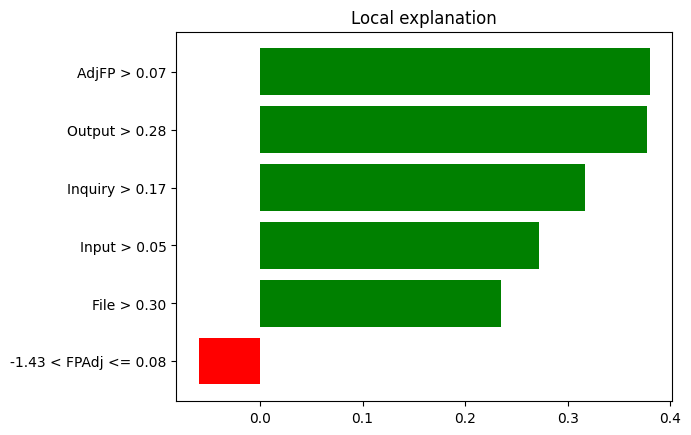

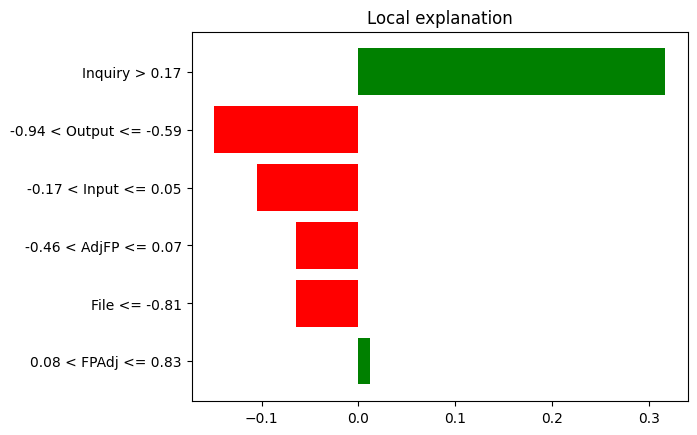

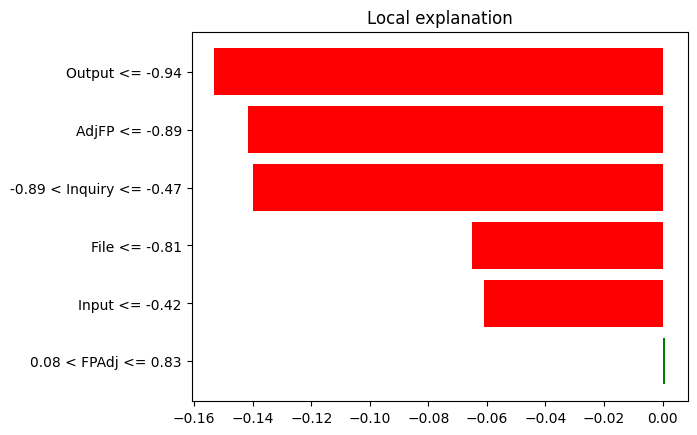

In [ ]:
lime_max.plot()
lime_median.plot()
lime_min.plot()

In [ ]:
lime_max.show_in_notebook()
lime_median.show_in_notebook()
lime_min.show_in_notebook()

### MAX:

In [ ]:
breakdown_df_max = breakdown_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_max = breakdown_df_max.drop(index=[0, 7])
breakdown_df_max['sign'] = breakdown_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_max = breakdown_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_max = shap_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_max = shap_df_max.tail(6)
shap_df_max['sign'] = shap_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_max = shap_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_max["Variable"] = lime_df_max["variable"].str.split(" ").str[0]
lime_df_max["Signo"] = lime_df_max["effect"].apply(evaluar_valor)
lime_df_max = lime_df_max.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_max = lime_df_max.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_max['Ranking'] = breakdown_df_max['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_max = breakdown_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_max['Ranking'] = shap_df_max['contribution'].abs().rank(ascending=False).astype(int)
shap_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_max = shap_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_max['Ranking'] = lime_df_max['effect'].abs().rank(ascending=False).astype(int)
lime_df_max = lime_df_max.head(5)
lime_df_max = lime_df_max[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_max = breakdown_df_max.drop(columns=['contribution'])
shap_df_max = shap_df_max.drop(columns=['contribution'])
lime_df_max = lime_df_max.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_max = breakdown_df_max.head(5)
breakdown_df_max = breakdown_df_max.reset_index(drop=True)

shap_df_max = shap_df_max.head(5)
shap_df_max = shap_df_max.reset_index(drop=True)

lime_df_max = lime_df_max.reset_index(drop=True)

print(breakdown_df_max)
print(shap_df_max)
print(lime_df_max)

  Variable  Ranking     Signo
0    Input        1  Positivo
1    AdjFP        2  Positivo
2   Output        3  Positivo
3     File        4  Positivo
4  Inquiry        5  Positivo
  Variable  Ranking     Signo
0    Input        1  Positivo
1    AdjFP        2  Positivo
2  Inquiry        3  Positivo
3   Output        4  Positivo
4     File        5  Positivo
  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2  Inquiry        3  Positivo
3    Input        4  Positivo
4     File        5  Positivo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_max['Variable'])
shapley_features = list(shap_df_max['Variable'])
lime_features = list(lime_df_max['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_max = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_max['Variable'] = list(all_features)
df_final_max= df_final_max[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_max['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_max[breakdown_df_max['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_max[shap_df_max['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_max[lime_df_max['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_max

['Input', 'AdjFP', 'Output', 'File', 'Inquiry']
['Input', 'AdjFP', 'Inquiry', 'Output', 'File']
['AdjFP', 'Output', 'Inquiry', 'Input', 'File']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         4  Positivo       5  Positivo       5  Positivo
1    Input         1  Positivo       1  Positivo       4  Positivo
2    AdjFP         2  Positivo       2  Positivo       1  Positivo
3   Output         3  Positivo       4  Positivo       2  Positivo
4  Inquiry         5  Positivo       3  Positivo       3  Positivo

In [ ]:
df_final_max.set_index('Variable', inplace=True)
nuevo_orden = ["Input", "AdjFP", "Output", "File", "Inquiry"]

# Reorganizar el DataFrame según el nuevo orden
df_final_max = df_final_max.reindex(nuevo_orden)

df_final_max

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Input            1  Positivo       1  Positivo       4  Positivo
AdjFP            2  Positivo       2  Positivo       1  Positivo
Output           3  Positivo       4  Positivo       2  Positivo
File             4  Positivo       5  Positivo       5  Positivo
Inquiry          5  Positivo       3  Positivo       3  Positivo

### MEDIAN:

In [ ]:
breakdown_df_median = breakdown_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_median = breakdown_df_median.drop(index=[0, 7])
breakdown_df_median['sign'] = breakdown_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_median = breakdown_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_median = shap_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_median = shap_df_median.tail(6)
shap_df_median['sign'] = shap_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_median = shap_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_median["Variable"] = lime_df_median["variable"].str.split(" ").str[0]
lime_df_median["Signo"] = lime_df_median["effect"].apply(evaluar_valor)
lime_df_median = lime_df_median.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_median = lime_df_median.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_median['Ranking'] = breakdown_df_median['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_median = breakdown_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_median['Ranking'] = shap_df_median['contribution'].abs().rank(ascending=False).astype(int)
shap_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_median = shap_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_median['Ranking'] = lime_df_median['effect'].abs().rank(ascending=False).astype(int)
lime_df_median = lime_df_median.head(5)
lime_df_median = lime_df_median[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_median = breakdown_df_median.drop(columns=['contribution'])
shap_df_median = shap_df_median.drop(columns=['contribution'])
lime_df_median = lime_df_median.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_median = breakdown_df_median.head(5)
breakdown_df_median = breakdown_df_median.reset_index(drop=True)

shap_df_median = shap_df_median.head(5)
shap_df_median = shap_df_median.reset_index(drop=True)

lime_df_median = lime_df_median.reset_index(drop=True)
lime_df_median.at[1, "Variable"]="Output"
lime_df_median.at[2, "Variable"]="Input"
lime_df_median.at[3, "Variable"]="AdjFP"

print(breakdown_df_median)
print(shap_df_median)
print(lime_df_median)

  Variable  Ranking     Signo
0  Inquiry        1  Positivo
1   Output        2  Negativo
2     File        3  Negativo
3    FPAdj        4  Positivo
4    AdjFP        5  Negativo
  Variable  Ranking     Signo
0  Inquiry        1  Positivo
1   Output        2  Negativo
2    Input        3  Negativo
3    AdjFP        4  Negativo
4     File        5  Negativo
  Variable  Ranking     Signo
0  Inquiry        1  Positivo
1   Output        2  Negativo
2    Input        3  Negativo
3    AdjFP        4  Negativo
4     File        5  Negativo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_median['Variable'])
shapley_features = list(shap_df_median['Variable'])
lime_features = list(lime_df_median['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_median = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_median['Variable'] = list(all_features)
df_final_median= df_final_median[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_median['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_median[breakdown_df_median['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_median[shap_df_median['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_median[lime_df_median['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_median

['Inquiry', 'Output', 'File', 'FPAdj', 'AdjFP']
['Inquiry', 'Output', 'Input', 'AdjFP', 'File']
['Inquiry', 'Output', 'Input', 'AdjFP', 'File']
['File', 'Input', 'AdjFP', 'Output', 'FPAdj', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         3  Negativo       5  Negativo       5  Negativo
1    Input         -         -       3  Negativo       3  Negativo
2    AdjFP         5  Negativo       4  Negativo       4  Negativo
3   Output         2  Negativo       2  Negativo       2  Negativo
4    FPAdj         4  Positivo       -         -       -         -
5  Inquiry         1  Positivo       1  Positivo       1  Positivo

In [ ]:
df_final_median.set_index('Variable', inplace=True)
nuevo_orden = ["Inquiry", "Output", "File", "FPAdj", "AdjFP", "Input"]

# Reorganizar el DataFrame según el nuevo orden
df_final_median = df_final_median.reindex(nuevo_orden)

df_final_median

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Inquiry          1  Positivo       1  Positivo       1  Positivo
Output           2  Negativo       2  Negativo       2  Negativo
File             3  Negativo       5  Negativo       5  Negativo
FPAdj            4  Positivo       -         -       -         -
AdjFP            5  Negativo       4  Negativo       4  Negativo
Input            -         -       3  Negativo       3  Negativo

### MIN:

In [ ]:
breakdown_df_min = breakdown_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_min = breakdown_df_min.drop(index=[0, 7])
breakdown_df_min['sign'] = breakdown_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_min = breakdown_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_min = shap_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_min = shap_df_min.tail(6)
shap_df_min['sign'] = shap_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_min = shap_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_min["Variable"] = lime_df_min["variable"].str.split(" ").str[0]
lime_df_min["Signo"] = lime_df_min["effect"].apply(evaluar_valor)
lime_df_min = lime_df_min.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_min = lime_df_min.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_min['Ranking'] = breakdown_df_min['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_min = breakdown_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_min['Ranking'] = shap_df_min['contribution'].abs().rank(ascending=False).astype(int)
shap_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_min = shap_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_min['Ranking'] = lime_df_min['effect'].abs().rank(ascending=False).astype(int)
lime_df_min = lime_df_min.head(5)
lime_df_min = lime_df_min[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_min = breakdown_df_min.drop(columns=['contribution'])
shap_df_min = shap_df_min.drop(columns=['contribution'])
lime_df_min = lime_df_min.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_min = breakdown_df_min.head(5)
breakdown_df_min = breakdown_df_min.reset_index(drop=True)

shap_df_min = shap_df_min.head(5)
shap_df_min = shap_df_min.reset_index(drop=True)

lime_df_min = lime_df_min.reset_index(drop=True)
lime_df_min.at[2, "Variable"] = "Inquiry"

print(breakdown_df_min)
print(shap_df_min)
print(lime_df_min)

  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2  Inquiry        3  Negativo
3     File        4  Negativo
4    FPAdj        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2  Inquiry        3  Negativo
3     File        4  Negativo
4    FPAdj        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2  Inquiry        3  Negativo
3     File        4  Negativo
4    Input        5  Negativo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_min['Variable'])
shapley_features = list(shap_df_min['Variable'])
lime_features = list(lime_df_min['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_min = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_min['Variable'] = list(all_features)
df_final_min= df_final_min[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_min['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_min[breakdown_df_min['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_min[shap_df_min['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_min[lime_df_min['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_min

['Output', 'AdjFP', 'Inquiry', 'File', 'FPAdj']
['Output', 'AdjFP', 'Inquiry', 'File', 'FPAdj']
['Output', 'AdjFP', 'Inquiry', 'File', 'Input']
['File', 'Input', 'AdjFP', 'Output', 'FPAdj', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         4  Negativo       4  Negativo       4  Negativo
1    Input         -         -       -         -       5  Negativo
2    AdjFP         2  Negativo       2  Negativo       2  Negativo
3   Output         1  Negativo       1  Negativo       1  Negativo
4    FPAdj         5  Negativo       5  Negativo       -         -
5  Inquiry         3  Negativo       3  Negativo       3  Negativo

In [ ]:
df_final_min.set_index('Variable', inplace=True)
nuevo_orden = ["Output", "AdjFP", "Inquiry", "File", "FPAdj", "Input"]

# Reorganizar el DataFrame según el nuevo orden
df_final_min = df_final_min.reindex(nuevo_orden)

df_final_min

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Output           1  Negativo       1  Negativo       1  Negativo
AdjFP            2  Negativo       2  Negativo       2  Negativo
Inquiry          3  Negativo       3  Negativo       3  Negativo
File             4  Negativo       4  Negativo       4  Negativo
FPAdj            5  Negativo       5  Negativo       -         -
Input            -         -       -         -       5  Negativo

### GLOBAL

In [ ]:
ranking_valores = {
    'Breakdown': [],
    'Shapley': [],
    'Lime': []
}

# Recorre los DataFrames y almacena los pares de valores por técnica
for tecnica in ranking_valores:
    for caracteristica in df_final_max.index:
        ranking = df_final_max[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_median.index:
        ranking = df_final_median[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_min.index:
        ranking = df_final_min[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

# Calcula el ranking medio por técnica y característica
ranking_medio = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, ranking in ranking_values:
        if caracteristica not in ranking_medio[tecnica]:
            ranking_medio[tecnica][caracteristica] = [ranking]
        else:
            ranking_medio[tecnica][caracteristica].append(ranking)

for tecnica, ranking_values in ranking_medio.items():
    for caracteristica in ranking_values:
        ranking_medio[tecnica][caracteristica] = sum(ranking_values[caracteristica]) / len(ranking_values[caracteristica])


# Ahora el conteo de apariciones por característica y técnica
apariciones_count = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, _ in ranking_values:
        if caracteristica not in apariciones_count[tecnica]:
            apariciones_count[tecnica][caracteristica] = 1
        else:
            apariciones_count[tecnica][caracteristica] += 1

# Tengo los valores, los conteos de apariciones y los ranking medios por técnica en los respectivos diccionarios
print(ranking_valores)
print(apariciones_count)
print(ranking_medio)

{'Breakdown': [('Input', 1), ('AdjFP', 2), ('Output', 3), ('File', 4), ('Inquiry', 5), ('Inquiry', 1), ('Output', 2), ('File', 3), ('FPAdj', 4), ('AdjFP', 5), ('Output', 1), ('AdjFP', 2), ('Inquiry', 3), ('File', 4), ('FPAdj', 5)], 'Shapley': [('Input', 1), ('AdjFP', 2), ('Output', 4), ('File', 5), ('Inquiry', 3), ('Inquiry', 1), ('Output', 2), ('File', 5), ('AdjFP', 4), ('Input', 3), ('Output', 1), ('AdjFP', 2), ('Inquiry', 3), ('File', 4), ('FPAdj', 5)], 'Lime': [('Input', 4), ('AdjFP', 1), ('Output', 2), ('File', 5), ('Inquiry', 3), ('Inquiry', 1), ('Output', 2), ('File', 5), ('AdjFP', 4), ('Input', 3), ('Output', 1), ('AdjFP', 2), ('Inquiry', 3), ('File', 4), ('Input', 5)]}
{'Breakdown': {'Input': 1, 'AdjFP': 3, 'Output': 3, 'File': 3, 'Inquiry': 3, 'FPAdj': 2}, 'Shapley': {'Input': 2, 'AdjFP': 3, 'Output': 3, 'File': 3, 'Inquiry': 3, 'FPAdj': 1}, 'Lime': {'Input': 3, 'AdjFP': 3, 'Output': 3, 'File': 3, 'Inquiry': 3}}
{'Breakdown': {'Input': 1.0, 'AdjFP': 3.0, 'Output': 2.0, 'File'

In [ ]:
# Lista de técnicas
techniques = ['Breakdown', 'Shapley', 'Lime']

# Diccionario para almacenar los datos
data_dict = {}

# Crear una lista de todas las características
all_caract = list(set().union(*[set(ranking_medio[technique]) for technique in techniques]))

# Recorrer las técnicas y las características
for technique in techniques:
    caract = list(ranking_medio[technique].keys())
    rank = [ranking_medio[technique].get(c, "-") for c in all_caract]
    apar = [apariciones_count[technique].get(c, "-") for c in all_caract]

    # Agregar los datos al diccionario
    data_dict[(technique, "Ranking Medio")] = rank
    data_dict[(technique, "Conteo")] = apar

# Crear el DataFrame resumen
df_resumen_svr = pd.DataFrame(data_dict, index=all_caract)

df_resumen_svr

Breakdown              Shapley                 Lime       
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo
Inquiry      3.000000      3      2.333333      3      2.333333      3
FPAdj        4.500000      2      5.000000      1             -      -
Output       2.000000      3      2.333333      3      1.666667      3
AdjFP        3.000000      3      2.666667      3      2.333333      3
Input        1.000000      1      2.000000      2           4.0      3
File         3.666667      3      4.666667      3      4.666667      3

In [ ]:
# Calcular el ranking medio general omitiendo los valores "-"
df_resumen_svr[("General", "Ranking")] = df_resumen_svr[[(tech, "Ranking Medio") for tech in techniques]].replace('-', np.nan).mean(axis=1)

# Calcular la suma total de apariciones omitiendo los valores "-"
df_resumen_svr[("General", "Conteo Total")] = df_resumen_svr[[(tech, "Conteo") for tech in techniques]].replace('-', 0).sum(axis=1)

# Mostrar el DataFrame resumen actualizado
df_resumen_svr

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry      3.000000      3      2.333333      3      2.333333      3   
FPAdj        4.500000      2      5.000000      1             -      -   
Output       2.000000      3      2.333333      3      1.666667      3   
AdjFP        3.000000      3      2.666667      3      2.333333      3   
Input        1.000000      1      2.000000      2           4.0      3   
File         3.666667      3      4.666667      3      4.666667      3   

          General               
          Ranking Conteo Total  
Inquiry  2.555556            9  
FPAdj    4.750000            3  
Output   2.000000            9  
AdjFP    2.666667            9  
Input    2.333333            6  
File     4.333333            9

In [ ]:
# Obtener el número de características
num_caract = df_resumen_svr.shape[0]

# Calcular el peso para el ranking y apariciones
df_resumen_svr[("General", "Peso Rango")] = 1 - ((df_resumen_svr[("General", "Ranking")].rank(ascending=True) - 1) / num_caract)
df_resumen_svr[("General", "Peso Conteo")] = df_resumen_svr[("General", "Conteo Total")].rank(ascending=True) / num_caract

# Calcular el puntaje final como suma de los pesos
df_resumen_svr[("General", "Puntaje")] = df_resumen_svr[("General", "Peso Rango")] + df_resumen_svr[("General", "Peso Conteo")]
df_resumen_svr[("General", "Ranking")] = df_resumen_svr[("General", "Puntaje")].rank(ascending=False, method="min")

# Eliminar la subcolumnas innecesarias
df_resumen_svr.drop("Peso Rango", axis=1, level=1, inplace=True)
df_resumen_svr.drop("Peso Conteo", axis=1, level=1, inplace=True)
df_resumen_svr.drop("Puntaje", axis=1, level=1, inplace=True)

df_resumen_svr

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry      3.000000      3      2.333333      3      2.333333      3   
FPAdj        4.500000      2      5.000000      1             -      -   
Output       2.000000      3      2.333333      3      1.666667      3   
AdjFP        3.000000      3      2.666667      3      2.333333      3   
Input        1.000000      1      2.000000      2           4.0      3   
File         3.666667      3      4.666667      3      4.666667      3   

        General               
        Ranking Conteo Total  
Inquiry     2.0            9  
FPAdj       6.0            3  
Output      1.0            9  
AdjFP       3.0            9  
Input       4.0            6  
File        5.0            9

In [ ]:
# Obtener las columnas actuales del DataFrame
columns = df_resumen_svr.columns

# Extraer las columnas de "General" y sus subcolumnas
general_columns = columns.get_level_values(0) == "General"

# Crear una lista con las subcolumnas de "General"
general_subcolumns = [("General", "Ranking"), ("General", "Conteo Total")]

# Crear una lista con las subcolumnas asociadas a las técnicas
technique_subcolumns = list(columns[~general_columns])

# Reorganizar las columnas para mover "General" al principio
new_columns = general_subcolumns + technique_subcolumns

# Crear un nuevo DataFrame con las columnas reorganizadas
df_resumen_svr = df_resumen_svr[new_columns]

In [ ]:
df_resumen_svr.sort_values(by=("General", "Ranking"), ascending=True, inplace=True)

# Formatear los valores
for tech in techniques:
    df_resumen_svr[(tech, "Ranking Medio")] = df_resumen_svr[(tech, "Ranking Medio")].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

df_resumen_svr

General                  Breakdown              Shapley         \
        Ranking Conteo Total Ranking Medio Conteo Ranking Medio Conteo   
Output      1.0            9          2.00      3          2.33      3   
Inquiry     2.0            9          3.00      3          2.33      3   
AdjFP       3.0            9          3.00      3          2.67      3   
Input       4.0            6          1.00      1          2.00      2   
File        5.0            9          3.67      3          4.67      3   
FPAdj       6.0            3          4.50      2          5.00      1   

                 Lime         
        Ranking Medio Conteo  
Output           1.67      3  
Inquiry          2.33      3  
AdjFP            2.33      3  
Input            4.00      3  
File             4.67      3  
FPAdj               -      -

## **RandomForest:**

**FEATURE IMPORTANCE:**

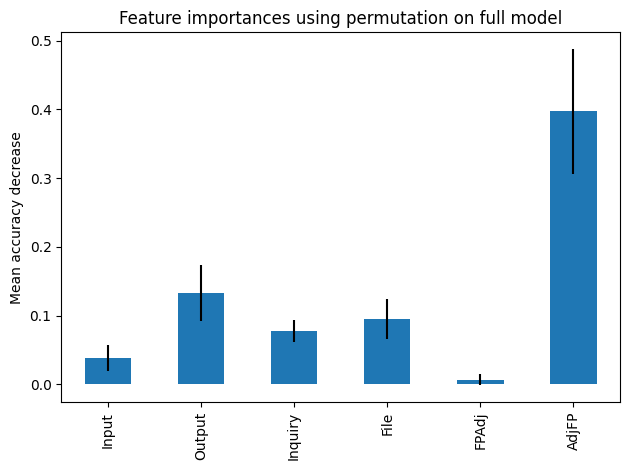

In [ ]:
# uso de permutation importance
permu = permutation_importance(modelo_rf, x_test, y_test, n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=feature_names)[permu.importances_mean.round(3) > 0.000]
fig, ax = plt.subplots()
permu_importances.plot.bar(yerr=permu.importances_std[permu.importances_mean.round(3) > 0.000], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

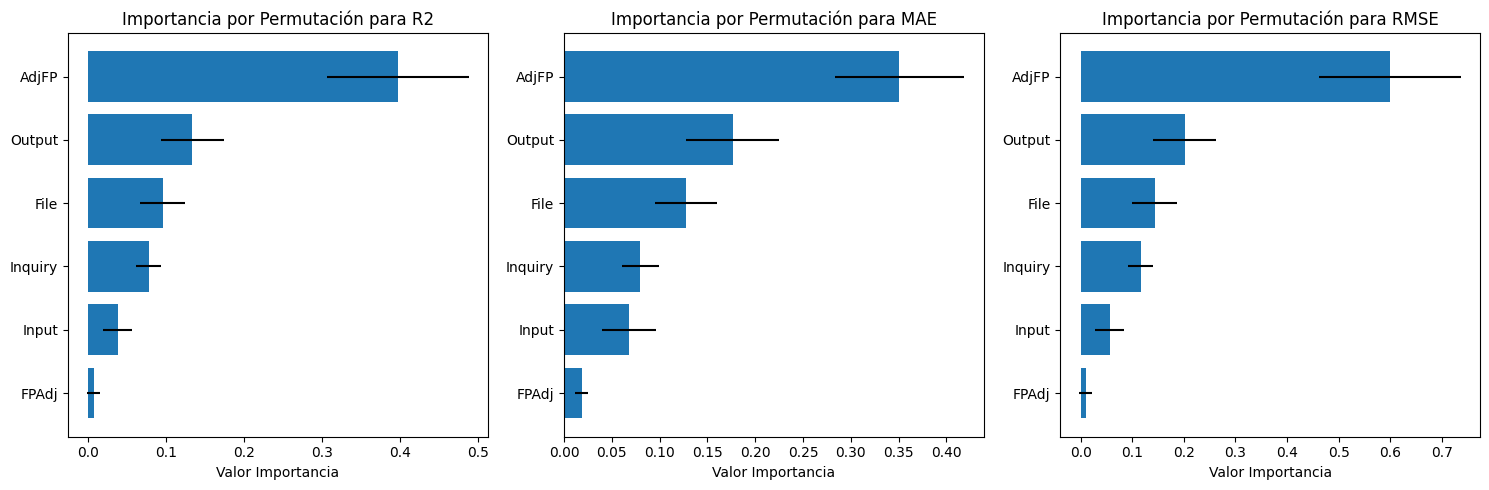

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
metric_names = ['R2', 'MAE', 'RMSE']

permu_score = permutation_importance(modelo_rf, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Itera a través de las métricas
for i, metric in enumerate(scoring):
    permu = permu_score[metric]

    # Filtra las características que cumplen la condición
    filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
    sorted_feature_names = [feature_names[j] for j in filtered_indices]
    importances_mean = permu.importances_mean[filtered_indices]
    importances_std = permu.importances_std[filtered_indices]

    # Ordena los datos por importancia de mayor a menor
    sorted_indices = np.argsort(importances_mean)[::1]
    sorted_feature_names = [sorted_feature_names[j] for j in sorted_indices]
    importances_mean = importances_mean[sorted_indices]
    importances_std = importances_std[sorted_indices]

    # Crea la representación gráfica en el subplot correspondiente
    axs[i].barh(range(len(sorted_feature_names)), importances_mean, xerr=importances_std, align='center')
    axs[i].set_yticks(range(len(sorted_feature_names)))
    axs[i].set_yticklabels(sorted_feature_names)
    axs[i].set_xlabel('Valor Importancia')
    axs[i].set_title(f'Importancia por Permutación para {metric_names[i]}')

# Ajusta los espacios entre subplots y muestra la figura
plt.tight_layout()
plt.show()

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

# Crea un diccionario para almacenar los DataFrames
results_global_rf = {}

permu_score = permutation_importance(modelo_rf, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
for i, metric in enumerate(scoring):
  permu = permu_score[metric]

  # Filtra las características que cumplen la condición
  filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
  sorted_feature_names = [feature_names[j] for j in filtered_indices]
  importances_mean = permu.importances_mean[filtered_indices]
  importances_std = permu.importances_std[filtered_indices]



  # Crear un DataFrame con los resultados
  df_exp_global = pd.DataFrame({'Feature': sorted_feature_names,
                       'Importance_Mean': importances_mean,
                       'Importance_Std': importances_std})

  # Ordenar el DataFrame por importance_mean en orden descendente
  df_exp_global = df_exp_global.sort_values(by='Importance_Mean', ascending=False)

  # Asignar el DataFrame al diccionario con el nombre de la métrica
  results_global_rf[f'df_global_{metric_names[i]}'] = df_exp_global

In [ ]:
results_global_rf['df_global_R2']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.396837,0.090696
1,Output,0.133470,0.040304
3,File,0.095165,0.028648
2,Inquiry,0.077213,0.015948
0,Input,0.037654,0.018638
4,FPAdj,0.006639,0.008303


In [ ]:
results_global_rf['df_global_MAE']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.350855,0.067542
1,Output,0.176389,0.048314
3,File,0.127579,0.032401
2,Inquiry,0.079935,0.018919
0,Input,0.067920,0.028673
4,FPAdj,0.018287,0.006973


In [ ]:
results_global_rf['df_global_RMSE']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.599523,0.137020
1,Output,0.201640,0.060889
3,File,0.143771,0.043279
2,Inquiry,0.116650,0.024094
0,Input,0.056886,0.028157
4,FPAdj,0.010029,0.012543


**BREAK-DOWN, SHAP Y LIME:**

In [ ]:
#primero definimos el explainer
exp = dx.Explainer(modelo_rf, x_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 33 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 33 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7e7270548d30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -0.718, mean = -0.263, max = 2.04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.198, mean = 0.0208, max = 0.955
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
#Primero obtenemos las instancias con valor estimado máximo, minimo y en la mediana.
max_index = np.argmax(y_pred)
min_index = np.argmin(y_pred)
mediana = np.median(y_pred)
#Encontrar el índice de la instancia cuyo valor estimado está en la mediana
median_index = np.argmin(np.abs(y_pred - mediana))

print("Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es: ", max_index)
print("El valor máximo obtenido es: ", y_pred[max_index])
print("Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es: ", min_index)
print("El valor mínimo obtenido es: ", y_pred[min_index])
print("Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana: ", median_index)
print("El valor de la mediana es: ", y_pred[median_index])

Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es:  7
El valor máximo obtenido es:  2.0403452718327033
Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es:  10
El valor mínimo obtenido es:  -0.7181503846175431
Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana:  11
El valor de la mediana es:  -0.3772526030475655


In [ ]:
df_instancia_max = x_test.iloc[max_index]
df_instancia_median = x_test.iloc[median_index]
df_instancia_min = x_test.iloc[min_index]

In [ ]:
breakdown_max = exp.predict_parts(df_instancia_max, type="break_down",random_state=42)
breakdown_median = exp.predict_parts(df_instancia_median, type="break_down",random_state=42)
breakdown_min = exp.predict_parts(df_instancia_min, type="break_down",random_state=42)

shap_max = exp.predict_parts(df_instancia_max, type="shap",random_state=42)
shap_median = exp.predict_parts(df_instancia_median, type="shap",random_state=42)
shap_min = exp.predict_parts(df_instancia_min, type="shap",random_state=42)

lime_max = exp.predict_surrogate(df_instancia_max, random_state=42)
lime_median = exp.predict_surrogate(df_instancia_median, random_state=42)
lime_min = exp.predict_surrogate(df_instancia_min, random_state=42)

breakdown_df_max = breakdown_max.result
shap_df_max = shap_max.result
lime_df_max=lime_max.result
breakdown_df_median = breakdown_median.result
shap_df_median = shap_median.result
lime_df_median= lime_median.result
breakdown_df_min = breakdown_min.result
shap_df_min = shap_min.result
lime_df_min = lime_min.result

In [ ]:
breakdown_max.plot()
breakdown_median.plot()
breakdown_min.plot()

In [ ]:
shap_max.plot()
shap_median.plot()
shap_min.plot()

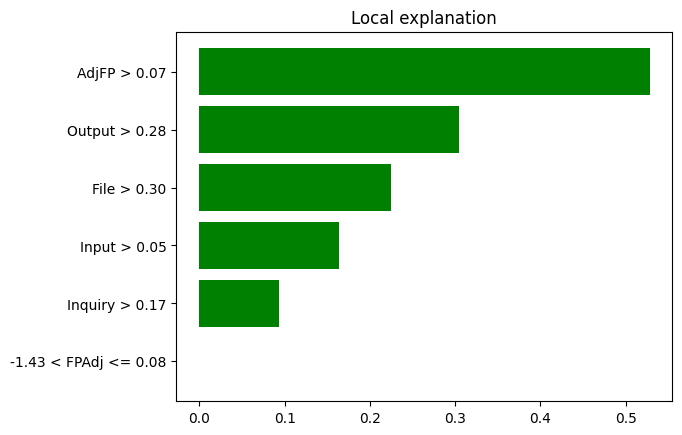

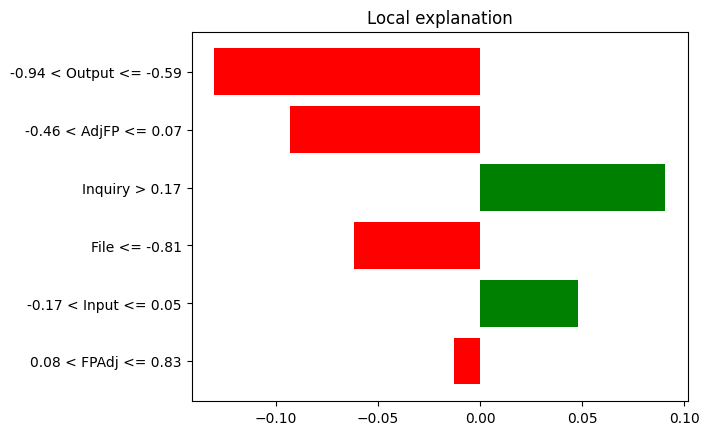

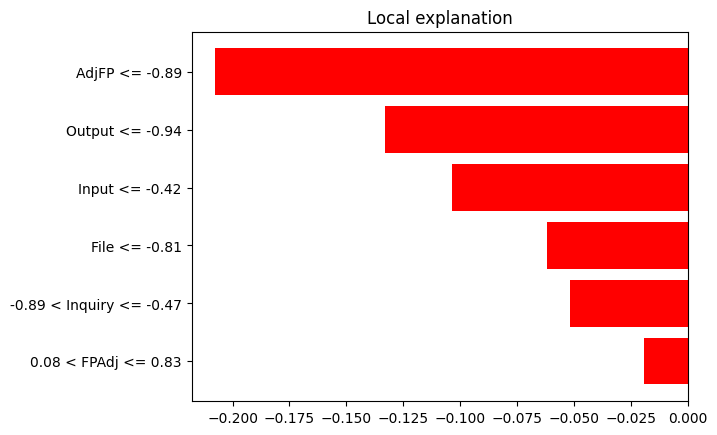

In [ ]:
lime_max.plot()
lime_median.plot()
lime_min.plot()

In [ ]:
lime_max.show_in_notebook()
lime_median.show_in_notebook()
lime_min.show_in_notebook()

### MAX:

In [ ]:
breakdown_df_max = breakdown_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_max = breakdown_df_max.drop(index=[0, 7])
breakdown_df_max['sign'] = breakdown_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_max = breakdown_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_max = shap_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_max = shap_df_max.tail(6)
shap_df_max['sign'] = shap_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_max = shap_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_max["Variable"] = lime_df_max["variable"].str.split(" ").str[0]
lime_df_max["Signo"] = lime_df_max["effect"].apply(evaluar_valor)
lime_df_max = lime_df_max.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_max = lime_df_max.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_max['Ranking'] = breakdown_df_max['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_max = breakdown_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_max['Ranking'] = shap_df_max['contribution'].abs().rank(ascending=False).astype(int)
shap_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_max = shap_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_max['Ranking'] = lime_df_max['effect'].abs().rank(ascending=False).astype(int)
lime_df_max = lime_df_max.head(5)
lime_df_max = lime_df_max[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_max = breakdown_df_max.drop(columns=['contribution'])
shap_df_max = shap_df_max.drop(columns=['contribution'])
lime_df_max = lime_df_max.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_max = breakdown_df_max.head(5)
breakdown_df_max = breakdown_df_max.reset_index(drop=True)

shap_df_max = shap_df_max.head(5)
shap_df_max = shap_df_max.reset_index(drop=True)

lime_df_max = lime_df_max.reset_index(drop=True)

print(breakdown_df_max)
print(shap_df_max)
print(lime_df_max)

  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2    Input        3  Positivo
3     File        4  Positivo
4  Inquiry        5  Positivo
  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2    Input        3  Positivo
3     File        4  Positivo
4  Inquiry        5  Positivo
  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2     File        3  Positivo
3    Input        4  Positivo
4  Inquiry        5  Positivo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_max['Variable'])
shapley_features = list(shap_df_max['Variable'])
lime_features = list(lime_df_max['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_max = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_max['Variable'] = list(all_features)
df_final_max= df_final_max[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_max['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_max[breakdown_df_max['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_max[shap_df_max['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_max[lime_df_max['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_max

['AdjFP', 'Output', 'Input', 'File', 'Inquiry']
['AdjFP', 'Output', 'Input', 'File', 'Inquiry']
['AdjFP', 'Output', 'File', 'Input', 'Inquiry']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         4  Positivo       4  Positivo       3  Positivo
1    Input         3  Positivo       3  Positivo       4  Positivo
2    AdjFP         1  Positivo       1  Positivo       1  Positivo
3   Output         2  Positivo       2  Positivo       2  Positivo
4  Inquiry         5  Positivo       5  Positivo       5  Positivo

In [ ]:
df_final_max.set_index('Variable', inplace=True)
nuevo_orden = ["AdjFP", "Output", "Input", "File", "Inquiry"]

# Reorganizar el DataFrame según el nuevo orden
df_final_max = df_final_max.reindex(nuevo_orden)

df_final_max

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
AdjFP            1  Positivo       1  Positivo       1  Positivo
Output           2  Positivo       2  Positivo       2  Positivo
Input            3  Positivo       3  Positivo       4  Positivo
File             4  Positivo       4  Positivo       3  Positivo
Inquiry          5  Positivo       5  Positivo       5  Positivo

### MEDIAN:

In [ ]:
breakdown_df_median = breakdown_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_median = breakdown_df_median.drop(index=[0, 7])
breakdown_df_median['sign'] = breakdown_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_median = breakdown_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_median = shap_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_median = shap_df_median.tail(6)
shap_df_median['sign'] = shap_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_median = shap_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_median["Variable"] = lime_df_median["variable"].str.split(" ").str[0]
lime_df_median["Signo"] = lime_df_median["effect"].apply(evaluar_valor)
lime_df_median = lime_df_median.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_median = lime_df_median.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_median['Ranking'] = breakdown_df_median['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_median = breakdown_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_median['Ranking'] = shap_df_median['contribution'].abs().rank(ascending=False).astype(int)
shap_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_median = shap_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_median['Ranking'] = lime_df_median['effect'].abs().rank(ascending=False).astype(int)
lime_df_median = lime_df_median.head(5)
lime_df_median = lime_df_median[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_median = breakdown_df_median.drop(columns=['contribution'])
shap_df_median = shap_df_median.drop(columns=['contribution'])
lime_df_median = lime_df_median.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_median = breakdown_df_median.head(5)
breakdown_df_median = breakdown_df_median.reset_index(drop=True)

shap_df_median = shap_df_median.head(5)
shap_df_median = shap_df_median.reset_index(drop=True)

lime_df_median = lime_df_median.reset_index(drop=True)
lime_df_median.at[0, "Variable"]="Output"
lime_df_median.at[1, "Variable"]="AdjFP"
lime_df_median.at[4, "Variable"]="Input"

print(breakdown_df_median)
print(shap_df_median)
print(lime_df_median)

  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2    Input        3  Positivo
3     File        4  Negativo
4    FPAdj        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2     File        3  Negativo
3    Input        4  Positivo
4  Inquiry        5  Positivo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2  Inquiry        3  Positivo
3     File        4  Negativo
4    Input        5  Positivo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_median['Variable'])
shapley_features = list(shap_df_median['Variable'])
lime_features = list(lime_df_median['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_median = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_median['Variable'] = list(all_features)
df_final_median= df_final_median[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_median['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_median[breakdown_df_median['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_median[shap_df_median['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_median[lime_df_median['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_median

['Output', 'AdjFP', 'Input', 'File', 'FPAdj']
['Output', 'AdjFP', 'File', 'Input', 'Inquiry']
['Output', 'AdjFP', 'Inquiry', 'File', 'Input']
['File', 'Input', 'AdjFP', 'Output', 'FPAdj', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         4  Negativo       3  Negativo       4  Negativo
1    Input         3  Positivo       4  Positivo       5  Positivo
2    AdjFP         2  Negativo       2  Negativo       2  Negativo
3   Output         1  Negativo       1  Negativo       1  Negativo
4    FPAdj         5  Negativo       -         -       -         -
5  Inquiry         -         -       5  Positivo       3  Positivo

In [ ]:
df_final_median.set_index('Variable', inplace=True)

nuevo_orden = ["Output","AdjFP", "Input", "File", "FPAdj", "Inquiry"]

# Reorganizar el DataFrame según el nuevo orden
df_final_median = df_final_median.reindex(nuevo_orden)

df_final_median

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Output           1  Negativo       1  Negativo       1  Negativo
AdjFP            2  Negativo       2  Negativo       2  Negativo
Input            3  Positivo       4  Positivo       5  Positivo
File             4  Negativo       3  Negativo       4  Negativo
FPAdj            5  Negativo       -         -       -         -
Inquiry          -         -       5  Positivo       3  Positivo

### MIN:

In [ ]:
breakdown_df_min = breakdown_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_min = breakdown_df_min.drop(index=[0, 7])
breakdown_df_min['sign'] = breakdown_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_min = breakdown_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_min = shap_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_min = shap_df_min.tail(6)
shap_df_min['sign'] = shap_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_min = shap_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_min["Variable"] = lime_df_min["variable"].str.split(" ").str[0]
lime_df_min["Signo"] = lime_df_min["effect"].apply(evaluar_valor)
lime_df_min = lime_df_min.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_min = lime_df_min.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_min['Ranking'] = breakdown_df_min['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_min = breakdown_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_min['Ranking'] = shap_df_min['contribution'].abs().rank(ascending=False).astype(int)
shap_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_min = shap_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_min['Ranking'] = lime_df_min['effect'].abs().rank(ascending=False).astype(int)
lime_df_min = lime_df_min.head(5)
lime_df_min = lime_df_min[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_min = breakdown_df_min.drop(columns=['contribution'])
shap_df_min = shap_df_min.drop(columns=['contribution'])
lime_df_min = lime_df_min.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_min = breakdown_df_min.head(5)
breakdown_df_min = breakdown_df_min.reset_index(drop=True)

shap_df_min = shap_df_min.head(5)
shap_df_min = shap_df_min.reset_index(drop=True)

lime_df_min = lime_df_min.reset_index(drop=True)
lime_df_min.at[4, "Variable"]="Inquiry"

print(breakdown_df_min)
print(shap_df_min)
print(lime_df_min)

  Variable  Ranking     Signo
0    AdjFP        1  Negativo
1   Output        2  Negativo
2    Input        3  Negativo
3     File        4  Negativo
4  Inquiry        5  Negativo
  Variable  Ranking     Signo
0    AdjFP        1  Negativo
1   Output        2  Negativo
2    Input        3  Negativo
3     File        4  Negativo
4  Inquiry        5  Negativo
  Variable  Ranking     Signo
0    AdjFP        1  Negativo
1   Output        2  Negativo
2    Input        3  Negativo
3     File        4  Negativo
4  Inquiry        5  Negativo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_min['Variable'])
shapley_features = list(shap_df_min['Variable'])
lime_features = list(lime_df_min['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_min = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_min['Variable'] = list(all_features)
df_final_min= df_final_min[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_min['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_min[breakdown_df_min['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_min[shap_df_min['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_min[lime_df_min['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_min

['AdjFP', 'Output', 'Input', 'File', 'Inquiry']
['AdjFP', 'Output', 'Input', 'File', 'Inquiry']
['AdjFP', 'Output', 'Input', 'File', 'Inquiry']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         4  Negativo       4  Negativo       4  Negativo
1    Input         3  Negativo       3  Negativo       3  Negativo
2    AdjFP         1  Negativo       1  Negativo       1  Negativo
3   Output         2  Negativo       2  Negativo       2  Negativo
4  Inquiry         5  Negativo       5  Negativo       5  Negativo

In [ ]:
df_final_min.set_index('Variable', inplace=True)
nuevo_orden = ["AdjFP", "Output", "Input", "File", "Inquiry"]

# Reorganizar el DataFrame según el nuevo orden
df_final_min = df_final_min.reindex(nuevo_orden)

df_final_min

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
AdjFP            1  Negativo       1  Negativo       1  Negativo
Output           2  Negativo       2  Negativo       2  Negativo
Input            3  Negativo       3  Negativo       3  Negativo
File             4  Negativo       4  Negativo       4  Negativo
Inquiry          5  Negativo       5  Negativo       5  Negativo

### GLOBAL

In [ ]:
ranking_valores = {
    'Breakdown': [],
    'Shapley': [],
    'Lime': []
}

# Recorre los DataFrames y almacena los pares de valores por técnica
for tecnica in ranking_valores:
    for caracteristica in df_final_max.index:
        ranking = df_final_max[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_median.index:
        ranking = df_final_median[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_min.index:
        ranking = df_final_min[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

# Calcula el ranking medio por técnica y característica
ranking_medio = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, ranking in ranking_values:
        if caracteristica not in ranking_medio[tecnica]:
            ranking_medio[tecnica][caracteristica] = [ranking]
        else:
            ranking_medio[tecnica][caracteristica].append(ranking)

for tecnica, ranking_values in ranking_medio.items():
    for caracteristica in ranking_values:
        ranking_medio[tecnica][caracteristica] = sum(ranking_values[caracteristica]) / len(ranking_values[caracteristica])


# Ahora el conteo de apariciones por característica y técnica
apariciones_count = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, _ in ranking_values:
        if caracteristica not in apariciones_count[tecnica]:
            apariciones_count[tecnica][caracteristica] = 1
        else:
            apariciones_count[tecnica][caracteristica] += 1

# Tengo los valores, los conteos de apariciones y los ranking medios por técnica en los respectivos diccionarios
print(ranking_valores)
print(apariciones_count)
print(ranking_medio)

{'Breakdown': [('AdjFP', 1), ('Output', 2), ('Input', 3), ('File', 4), ('Inquiry', 5), ('Output', 1), ('AdjFP', 2), ('Input', 3), ('File', 4), ('FPAdj', 5), ('AdjFP', 1), ('Output', 2), ('Input', 3), ('File', 4), ('Inquiry', 5)], 'Shapley': [('AdjFP', 1), ('Output', 2), ('Input', 3), ('File', 4), ('Inquiry', 5), ('Output', 1), ('AdjFP', 2), ('Input', 4), ('File', 3), ('Inquiry', 5), ('AdjFP', 1), ('Output', 2), ('Input', 3), ('File', 4), ('Inquiry', 5)], 'Lime': [('AdjFP', 1), ('Output', 2), ('Input', 4), ('File', 3), ('Inquiry', 5), ('Output', 1), ('AdjFP', 2), ('Input', 5), ('File', 4), ('Inquiry', 3), ('AdjFP', 1), ('Output', 2), ('Input', 3), ('File', 4), ('Inquiry', 5)]}
{'Breakdown': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'File': 3, 'Inquiry': 2, 'FPAdj': 1}, 'Shapley': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'File': 3, 'Inquiry': 3}, 'Lime': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'File': 3, 'Inquiry': 3}}
{'Breakdown': {'AdjFP': 1.3333333333333333, 'Output': 1.6666666666666667, 'Inp

In [ ]:
# Lista de técnicas
techniques = ['Breakdown', 'Shapley', 'Lime']

# Diccionario para almacenar los datos
data_dict = {}

# Crear una lista de todas las características
all_caract = list(set().union(*[set(ranking_medio[technique]) for technique in techniques]))

# Recorrer las técnicas y las características
for technique in techniques:
    caract = list(ranking_medio[technique].keys())
    rank = [ranking_medio[technique].get(c, "-") for c in all_caract]
    apar = [apariciones_count[technique].get(c, "-") for c in all_caract]

    # Agregar los datos al diccionario
    data_dict[(technique, "Ranking Medio")] = rank
    data_dict[(technique, "Conteo")] = apar

# Crear el DataFrame resumen
df_resumen_rf = pd.DataFrame(data_dict, index=all_caract)

df_resumen_rf

Breakdown              Shapley                 Lime       
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo
Inquiry      5.000000      2           5.0      3      4.333333      3
FPAdj        5.000000      1             -      -             -      -
Output       1.666667      3      1.666667      3      1.666667      3
AdjFP        1.333333      3      1.333333      3      1.333333      3
Input        3.000000      3      3.333333      3           4.0      3
File         4.000000      3      3.666667      3      3.666667      3

In [ ]:
# Calcular el ranking medio general omitiendo los valores "-"
df_resumen_rf[("General", "Ranking")] = df_resumen_rf[[(tech, "Ranking Medio") for tech in techniques]].replace('-', np.nan).mean(axis=1)

# Calcular la suma total de apariciones omitiendo los valores "-"
df_resumen_rf[("General", "Conteo Total")] = df_resumen_rf[[(tech, "Conteo") for tech in techniques]].replace('-', 0).sum(axis=1)

# Mostrar el DataFrame resumen actualizado
df_resumen_rf

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry      5.000000      2           5.0      3      4.333333      3   
FPAdj        5.000000      1             -      -             -      -   
Output       1.666667      3      1.666667      3      1.666667      3   
AdjFP        1.333333      3      1.333333      3      1.333333      3   
Input        3.000000      3      3.333333      3           4.0      3   
File         4.000000      3      3.666667      3      3.666667      3   

          General               
          Ranking Conteo Total  
Inquiry  4.777778            8  
FPAdj    5.000000            1  
Output   1.666667            9  
AdjFP    1.333333            9  
Input    3.444444            9  
File     3.777778            9

In [ ]:
# Obtener el número de características
num_caract = df_resumen_rf.shape[0]

# Calcular el peso para el ranking y apariciones
df_resumen_rf[("General", "Peso Rango")] = 1 - ((df_resumen_rf[("General", "Ranking")].rank(ascending=True) - 1) / num_caract)
df_resumen_rf[("General", "Peso Conteo")] = df_resumen_rf[("General", "Conteo Total")].rank(ascending=True) / num_caract

# Calcular el puntaje final como suma de los pesos
df_resumen_rf[("General", "Puntaje")] = df_resumen_rf[("General", "Peso Rango")] + df_resumen_rf[("General", "Peso Conteo")]
df_resumen_rf[("General", "Ranking")] = df_resumen_rf[("General", "Puntaje")].rank(ascending=False, method="min")

# Eliminar la subcolumnas innecesarias
df_resumen_rf.drop("Peso Rango", axis=1, level=1, inplace=True)
df_resumen_rf.drop("Peso Conteo", axis=1, level=1, inplace=True)
df_resumen_rf.drop("Puntaje", axis=1, level=1, inplace=True)

df_resumen_rf

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry      5.000000      2           5.0      3      4.333333      3   
FPAdj        5.000000      1             -      -             -      -   
Output       1.666667      3      1.666667      3      1.666667      3   
AdjFP        1.333333      3      1.333333      3      1.333333      3   
Input        3.000000      3      3.333333      3           4.0      3   
File         4.000000      3      3.666667      3      3.666667      3   

        General               
        Ranking Conteo Total  
Inquiry     5.0            8  
FPAdj       6.0            1  
Output      2.0            9  
AdjFP       1.0            9  
Input       3.0            9  
File        4.0            9

In [ ]:
# Obtener las columnas actuales del DataFrame
columns = df_resumen_rf.columns

# Extraer las columnas de "General" y sus subcolumnas
general_columns = columns.get_level_values(0) == "General"

# Crear una lista con las subcolumnas de "General"
general_subcolumns = [("General", "Ranking"), ("General", "Conteo Total")]

# Crear una lista con las subcolumnas asociadas a las técnicas
technique_subcolumns = list(columns[~general_columns])

# Reorganizar las columnas para mover "General" al principio
new_columns = general_subcolumns + technique_subcolumns

# Crear un nuevo DataFrame con las columnas reorganizadas
df_resumen_rf = df_resumen_rf[new_columns]

In [ ]:
df_resumen_rf.sort_values(by=("General", "Ranking"), ascending=True, inplace=True)

# Formatear los valores
for tech in techniques:
    df_resumen_rf[(tech, "Ranking Medio")] = df_resumen_rf[(tech, "Ranking Medio")].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

df_resumen_rf

General                  Breakdown              Shapley         \
        Ranking Conteo Total Ranking Medio Conteo Ranking Medio Conteo   
AdjFP       1.0            9          1.33      3          1.33      3   
Output      2.0            9          1.67      3          1.67      3   
Input       3.0            9          3.00      3          3.33      3   
File        4.0            9          4.00      3          3.67      3   
Inquiry     5.0            8          5.00      2          5.00      3   
FPAdj       6.0            1          5.00      1             -      -   

                 Lime         
        Ranking Medio Conteo  
AdjFP            1.33      3  
Output           1.67      3  
Input            4.00      3  
File             3.67      3  
Inquiry          4.33      3  
FPAdj               -      -

## **GradientBoostingRegresor:**

**FEATURE IMPORTANCE:**

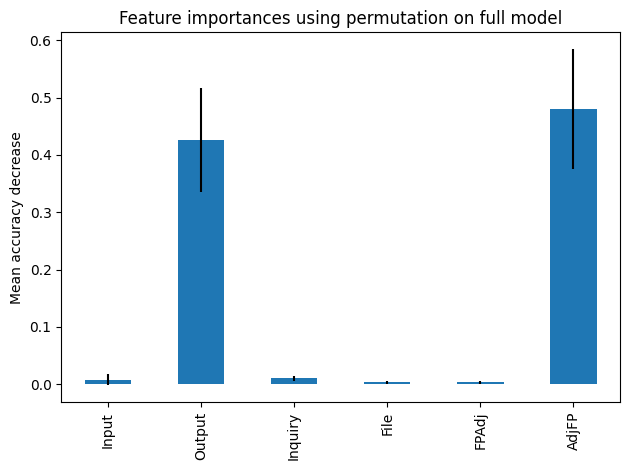

In [ ]:
# Uso de permutation importance
permu = permutation_importance(modelo_gbr, x_test, y_test, n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=feature_names)[permu.importances_mean.round(3) > 0.000]
fig, ax = plt.subplots()
permu_importances.plot.bar(yerr=permu.importances_std[permu.importances_mean.round(3) > 0.000], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

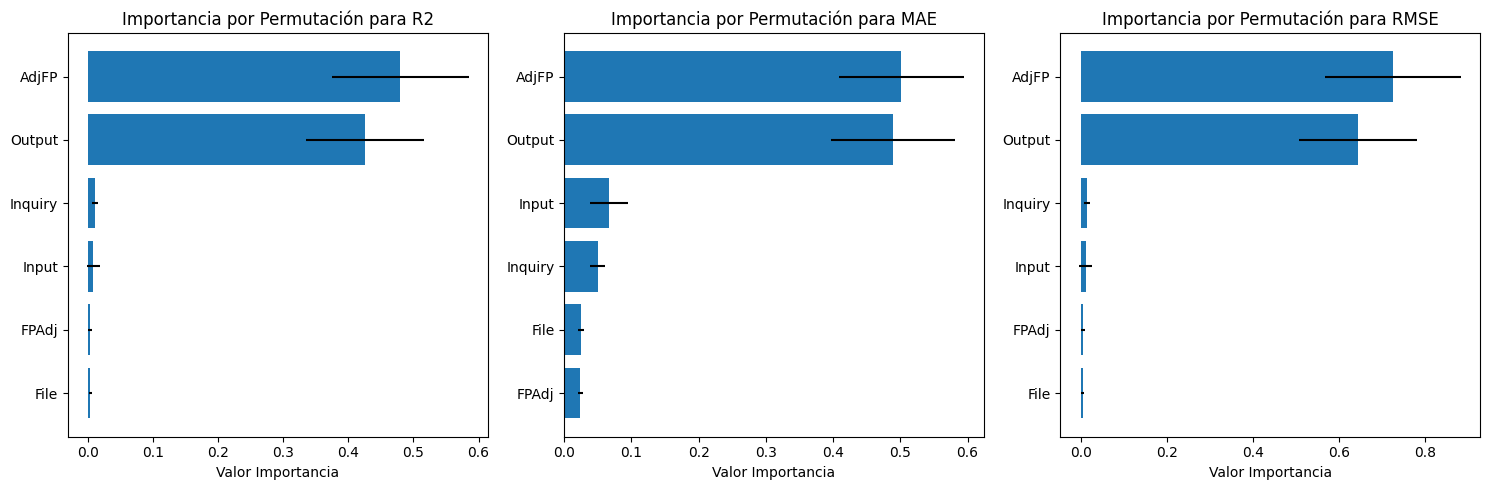

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
metric_names = ['R2', 'MAE', 'RMSE']

permu_score = permutation_importance(modelo_gbr, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Itera a través de las métricas
for i, metric in enumerate(scoring):
    permu = permu_score[metric]

    # Filtra las características que cumplen la condición
    filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
    sorted_feature_names = [feature_names[j] for j in filtered_indices]
    importances_mean = permu.importances_mean[filtered_indices]
    importances_std = permu.importances_std[filtered_indices]

    # Ordena los datos por importancia de mayor a menor
    sorted_indices = np.argsort(importances_mean)[::1]
    sorted_feature_names = [sorted_feature_names[j] for j in sorted_indices]
    importances_mean = importances_mean[sorted_indices]
    importances_std = importances_std[sorted_indices]

    # Crea la representación gráfica en el subplot correspondiente
    axs[i].barh(range(len(sorted_feature_names)), importances_mean, xerr=importances_std, align='center')
    axs[i].set_yticks(range(len(sorted_feature_names)))
    axs[i].set_yticklabels(sorted_feature_names)
    axs[i].set_xlabel('Valor Importancia')
    axs[i].set_title(f'Importancia por Permutación para {metric_names[i]}')

# Ajusta los espacios entre subplots y muestra la figura
plt.tight_layout()
plt.show()

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

# Crea un diccionario para almacenar los DataFrames
results_global_gbr = {}

permu_score = permutation_importance(modelo_gbr, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
for i, metric in enumerate(scoring):
  permu = permu_score[metric]

  # Filtra las características que cumplen la condición
  filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
  sorted_feature_names = [feature_names[j] for j in filtered_indices]
  importances_mean = permu.importances_mean[filtered_indices]
  importances_std = permu.importances_std[filtered_indices]



  # Crear un DataFrame con los resultados
  df_exp_global = pd.DataFrame({'Feature': sorted_feature_names,
                       'Importance_Mean': importances_mean,
                       'Importance_Std': importances_std})

  # Ordenar el DataFrame por importance_mean en orden descendente
  df_exp_global = df_exp_global.sort_values(by='Importance_Mean', ascending=False)

  # Asignar el DataFrame al diccionario con el nombre de la métrica
  results_global_gbr[f'df_global_{metric_names[i]}'] = df_exp_global

In [ ]:
results_global_gbr['df_global_R2']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.479994,0.104619
1,Output,0.425851,0.090974
2,Inquiry,0.010044,0.004455
0,Input,0.007803,0.009833
4,FPAdj,0.002873,0.002917
3,File,0.002795,0.002215


In [ ]:
results_global_gbr['df_global_MAE']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.501339,0.093005
1,Output,0.489043,0.092658
0,Input,0.067244,0.028182
2,Inquiry,0.049608,0.011678
3,File,0.025227,0.004609
4,FPAdj,0.024050,0.003624


In [ ]:
results_global_gbr['df_global_RMSE']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.725153,0.158054
1,Output,0.643356,0.137439
2,Inquiry,0.015174,0.006731
0,Input,0.011788,0.014855
4,FPAdj,0.004341,0.004407
3,File,0.004223,0.003346


**BREAK-DOWN, SHAP Y LIME:**

In [ ]:
#primero definimos el explainer
exp = dx.Explainer(modelo_gbr, x_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 33 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 33 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7e7270548d30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -0.758, mean = -0.242, max = 2.98
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.048, mean = -1.14e-17, max = 0.0431
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [ ]:
#Primero obtenemos las instancias con valor estimado máximo, minimo y en la mediana.
max_index = np.argmax(y_pred)
min_index = np.argmin(y_pred)
mediana = np.median(y_pred)
#Encontrar el índice de la instancia cuyo valor estimado está en la mediana
median_index = np.argmin(np.abs(y_pred - mediana))

print("Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es: ", max_index)
print("El valor máximo obtenido es: ", y_pred[max_index])
print("Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es: ", min_index)
print("El valor mínimo obtenido es: ", y_pred[min_index])
print("Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana: ", median_index)
print("El valor de la mediana es: ", y_pred[median_index])

Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es:  7
El valor máximo obtenido es:  2.9826035299844236
Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es:  10
El valor mínimo obtenido es:  -0.75785155409512
Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana:  11
El valor de la mediana es:  -0.37853902314170085


In [ ]:
df_instancia_max = x_test.iloc[max_index]
df_instancia_median = x_test.iloc[median_index]
df_instancia_min = x_test.iloc[min_index]

In [ ]:
breakdown_max = exp.predict_parts(df_instancia_max, type="break_down",random_state=42)
breakdown_median = exp.predict_parts(df_instancia_median, type="break_down",random_state=42)
breakdown_min = exp.predict_parts(df_instancia_min, type="break_down",random_state=42)

shap_max = exp.predict_parts(df_instancia_max, type="shap",random_state=42)
shap_median = exp.predict_parts(df_instancia_median, type="shap",random_state=42)
shap_min = exp.predict_parts(df_instancia_min, type="shap",random_state=42)

lime_max = exp.predict_surrogate(df_instancia_max, random_state=42)
lime_median = exp.predict_surrogate(df_instancia_median, random_state=42)
lime_min = exp.predict_surrogate(df_instancia_min, random_state=42)

breakdown_df_max = breakdown_max.result
shap_df_max = shap_max.result
lime_df_max=lime_max.result
breakdown_df_median = breakdown_median.result
shap_df_median = shap_median.result
lime_df_median= lime_median.result
breakdown_df_min = breakdown_min.result
shap_df_min = shap_min.result
lime_df_min = lime_min.result

In [ ]:
breakdown_max.plot()
breakdown_median.plot()
breakdown_min.plot()

In [ ]:
shap_max.plot()
shap_median.plot()
shap_min.plot()

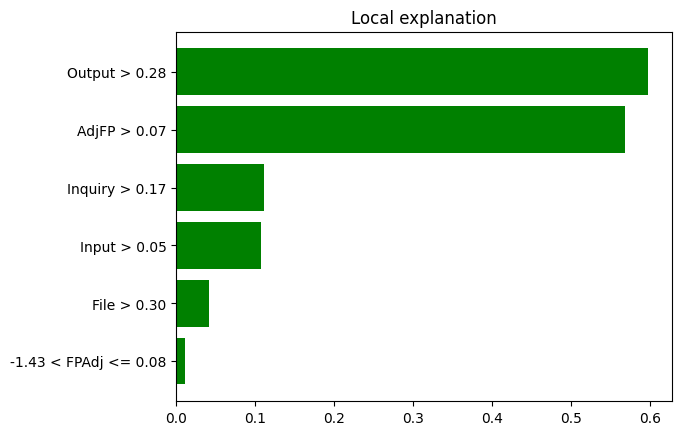

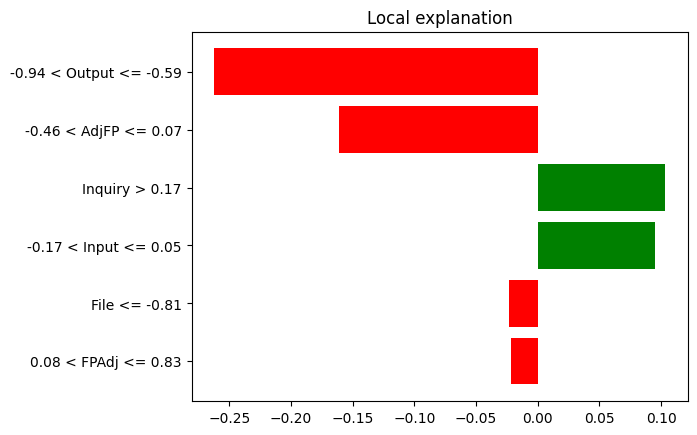

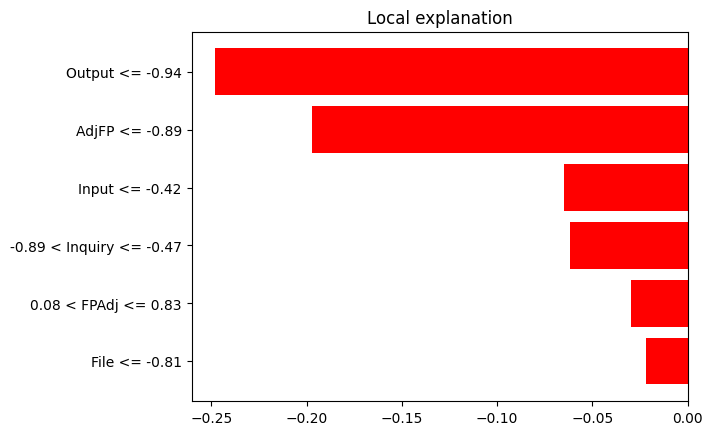

In [ ]:
lime_max.plot()
lime_median.plot()
lime_min.plot()

In [ ]:
lime_max.show_in_notebook()
lime_median.show_in_notebook()
lime_min.show_in_notebook()

### MAX:

In [ ]:
breakdown_df_max = breakdown_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_max = breakdown_df_max.drop(index=[0, 7])
breakdown_df_max['sign'] = breakdown_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_max = breakdown_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_max = shap_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_max = shap_df_max.tail(6)
shap_df_max['sign'] = shap_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_max = shap_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_max["Variable"] = lime_df_max["variable"].str.split(" ").str[0]
lime_df_max["Signo"] = lime_df_max["effect"].apply(evaluar_valor)
lime_df_max = lime_df_max.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_max = lime_df_max.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_max['Ranking'] = breakdown_df_max['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_max = breakdown_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_max['Ranking'] = shap_df_max['contribution'].abs().rank(ascending=False).astype(int)
shap_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_max = shap_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_max['Ranking'] = lime_df_max['effect'].abs().rank(ascending=False).astype(int)
lime_df_max = lime_df_max.head(5)
lime_df_max = lime_df_max[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_max = breakdown_df_max.drop(columns=['contribution'])
shap_df_max = shap_df_max.drop(columns=['contribution'])
lime_df_max = lime_df_max.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_max = breakdown_df_max.head(5)
breakdown_df_max = breakdown_df_max.reset_index(drop=True)

shap_df_max = shap_df_max.head(5)
shap_df_max = shap_df_max.reset_index(drop=True)

lime_df_max = lime_df_max.reset_index(drop=True)

print(breakdown_df_max)
print(shap_df_max)
print(lime_df_max)

  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2    Input        3  Positivo
3  Inquiry        4  Positivo
4     File        5  Positivo
  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2    Input        3  Positivo
3  Inquiry        4  Positivo
4     File        5  Positivo
  Variable  Ranking     Signo
0   Output        1  Positivo
1    AdjFP        2  Positivo
2  Inquiry        3  Positivo
3    Input        4  Positivo
4     File        5  Positivo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_max['Variable'])
shapley_features = list(shap_df_max['Variable'])
lime_features = list(lime_df_max['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_max = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_max['Variable'] = list(all_features)
df_final_max= df_final_max[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_max['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_max[breakdown_df_max['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_max[shap_df_max['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_max[lime_df_max['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_max

['AdjFP', 'Output', 'Input', 'Inquiry', 'File']
['AdjFP', 'Output', 'Input', 'Inquiry', 'File']
['Output', 'AdjFP', 'Inquiry', 'Input', 'File']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         5  Positivo       5  Positivo       5  Positivo
1    Input         3  Positivo       3  Positivo       4  Positivo
2    AdjFP         1  Positivo       1  Positivo       2  Positivo
3   Output         2  Positivo       2  Positivo       1  Positivo
4  Inquiry         4  Positivo       4  Positivo       3  Positivo

In [ ]:
df_final_max.set_index('Variable', inplace=True)
nuevo_orden = ["AdjFP", "Output", "Input", "Inquiry", "File"]

# Reorganizar el DataFrame según el nuevo orden
df_final_max = df_final_max.reindex(nuevo_orden)

df_final_max

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
AdjFP            1  Positivo       1  Positivo       2  Positivo
Output           2  Positivo       2  Positivo       1  Positivo
Input            3  Positivo       3  Positivo       4  Positivo
Inquiry          4  Positivo       4  Positivo       3  Positivo
File             5  Positivo       5  Positivo       5  Positivo

### MEDIAN:

In [ ]:
breakdown_df_median = breakdown_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_median = breakdown_df_median.drop(index=[0, 7])
breakdown_df_median['sign'] = breakdown_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_median = breakdown_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_median = shap_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_median = shap_df_median.tail(6)
shap_df_median['sign'] = shap_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_median = shap_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_median["Variable"] = lime_df_median["variable"].str.split(" ").str[0]
lime_df_median["Signo"] = lime_df_median["effect"].apply(evaluar_valor)
lime_df_median = lime_df_median.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_median = lime_df_median.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_median['Ranking'] = breakdown_df_median['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_median = breakdown_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_median['Ranking'] = shap_df_median['contribution'].abs().rank(ascending=False).astype(int)
shap_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_median = shap_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_median['Ranking'] = lime_df_median['effect'].abs().rank(ascending=False).astype(int)
lime_df_median = lime_df_median.head(5)
lime_df_median = lime_df_median[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_median = breakdown_df_median.drop(columns=['contribution'])
shap_df_median = shap_df_median.drop(columns=['contribution'])
lime_df_median = lime_df_median.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_median = breakdown_df_median.head(5)
breakdown_df_median = breakdown_df_median.reset_index(drop=True)

shap_df_median = shap_df_median.head(5)
shap_df_median = shap_df_median.reset_index(drop=True)

lime_df_median = lime_df_median.reset_index(drop=True)
lime_df_median.at[0, "Variable"]="Output"
lime_df_median.at[1, "Variable"]="AdjFP"
lime_df_median.at[3, "Variable"]="Input"

print(breakdown_df_median)
print(shap_df_median)
print(lime_df_median)

  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2    Input        3  Positivo
3  Inquiry        4  Positivo
4     File        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2    Input        3  Positivo
3  Inquiry        4  Positivo
4     File        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2  Inquiry        3  Positivo
3    Input        4  Positivo
4     File        5  Negativo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_median['Variable'])
shapley_features = list(shap_df_median['Variable'])
lime_features = list(lime_df_median['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_median = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_median['Variable'] = list(all_features)
df_final_median= df_final_median[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_median['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_median[breakdown_df_median['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_median[shap_df_median['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_median[lime_df_median['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_median

['Output', 'AdjFP', 'Input', 'Inquiry', 'File']
['Output', 'AdjFP', 'Input', 'Inquiry', 'File']
['Output', 'AdjFP', 'Inquiry', 'Input', 'File']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         5  Negativo       5  Negativo       5  Negativo
1    Input         3  Positivo       3  Positivo       4  Positivo
2    AdjFP         2  Negativo       2  Negativo       2  Negativo
3   Output         1  Negativo       1  Negativo       1  Negativo
4  Inquiry         4  Positivo       4  Positivo       3  Positivo

In [ ]:
df_final_median.set_index('Variable', inplace=True)
nuevo_orden = ["Output", "AdjFP", "Input", "Inquiry", "File"]

# Reorganizar el DataFrame según el nuevo orden
df_final_median = df_final_median.reindex(nuevo_orden)

df_final_median

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Output           1  Negativo       1  Negativo       1  Negativo
AdjFP            2  Negativo       2  Negativo       2  Negativo
Input            3  Positivo       3  Positivo       4  Positivo
Inquiry          4  Positivo       4  Positivo       3  Positivo
File             5  Negativo       5  Negativo       5  Negativo

### MIN:

In [ ]:
breakdown_df_min = breakdown_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_min = breakdown_df_min.drop(index=[0, 7])
breakdown_df_min['sign'] = breakdown_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_min = breakdown_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_min = shap_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_min = shap_df_min.tail(6)
shap_df_min['sign'] = shap_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_min = shap_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_min["Variable"] = lime_df_min["variable"].str.split(" ").str[0]
lime_df_min["Signo"] = lime_df_min["effect"].apply(evaluar_valor)
lime_df_min = lime_df_min.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_min = lime_df_min.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_min['Ranking'] = breakdown_df_min['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_min = breakdown_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_min['Ranking'] = shap_df_min['contribution'].abs().rank(ascending=False).astype(int)
shap_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_min = shap_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_min['Ranking'] = lime_df_min['effect'].abs().rank(ascending=False).astype(int)
lime_df_min = lime_df_min.head(5)
lime_df_min = lime_df_min[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_min = breakdown_df_min.drop(columns=['contribution'])
shap_df_min = shap_df_min.drop(columns=['contribution'])
lime_df_min = lime_df_min.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_min = breakdown_df_min.head(5)
breakdown_df_min = breakdown_df_min.reset_index(drop=True)

shap_df_min = shap_df_min.head(5)
shap_df_min = shap_df_min.reset_index(drop=True)

lime_df_min = lime_df_min.reset_index(drop=True)
lime_df_min.at[3, "Variable"]="Inquiry"
lime_df_min.at[4, "Variable"]="FPAdj"

print(breakdown_df_min)
print(shap_df_min)
print(lime_df_min)

  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2     File        3  Negativo
3  Inquiry        4  Negativo
4    Input        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2     File        3  Negativo
3  Inquiry        4  Negativo
4    Input        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2    Input        3  Negativo
3  Inquiry        4  Negativo
4    FPAdj        5  Negativo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_min['Variable'])
shapley_features = list(shap_df_min['Variable'])
lime_features = list(lime_df_min['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_min = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_min['Variable'] = list(all_features)
df_final_min= df_final_min[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_min['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_min[breakdown_df_min['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_min[shap_df_min['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_min[lime_df_min['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_min

['Output', 'AdjFP', 'File', 'Inquiry', 'Input']
['Output', 'AdjFP', 'File', 'Inquiry', 'Input']
['Output', 'AdjFP', 'Input', 'Inquiry', 'FPAdj']
['File', 'Input', 'AdjFP', 'Output', 'FPAdj', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         3  Negativo       3  Negativo       -         -
1    Input         5  Negativo       5  Negativo       3  Negativo
2    AdjFP         2  Negativo       2  Negativo       2  Negativo
3   Output         1  Negativo       1  Negativo       1  Negativo
4    FPAdj         -         -       -         -       5  Negativo
5  Inquiry         4  Negativo       4  Negativo       4  Negativo

In [ ]:
df_final_min.set_index('Variable', inplace=True)
nuevo_orden = ["Output", "AdjFP", "File", "Inquiry", "Input", "FPAdj"]

# Reorganizar el DataFrame según el nuevo orden
df_final_min = df_final_min.reindex(nuevo_orden)

df_final_min

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Output           1  Negativo       1  Negativo       1  Negativo
AdjFP            2  Negativo       2  Negativo       2  Negativo
File             3  Negativo       3  Negativo       -         -
Inquiry          4  Negativo       4  Negativo       4  Negativo
Input            5  Negativo       5  Negativo       3  Negativo
FPAdj            -         -       -         -       5  Negativo

### GLOBAL

In [ ]:
ranking_valores = {
    'Breakdown': [],
    'Shapley': [],
    'Lime': []
}

# Recorre los DataFrames y almacena los pares de valores por técnica
for tecnica in ranking_valores:
    for caracteristica in df_final_max.index:
        ranking = df_final_max[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_median.index:
        ranking = df_final_median[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_min.index:
        ranking = df_final_min[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

# Calcula el ranking medio por técnica y característica
ranking_medio = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, ranking in ranking_values:
        if caracteristica not in ranking_medio[tecnica]:
            ranking_medio[tecnica][caracteristica] = [ranking]
        else:
            ranking_medio[tecnica][caracteristica].append(ranking)

for tecnica, ranking_values in ranking_medio.items():
    for caracteristica in ranking_values:
        ranking_medio[tecnica][caracteristica] = sum(ranking_values[caracteristica]) / len(ranking_values[caracteristica])


# Ahora el conteo de apariciones por característica y técnica
apariciones_count = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, _ in ranking_values:
        if caracteristica not in apariciones_count[tecnica]:
            apariciones_count[tecnica][caracteristica] = 1
        else:
            apariciones_count[tecnica][caracteristica] += 1

# Tengo los valores, los conteos de apariciones y los ranking medios por técnica en los respectivos diccionarios
print(ranking_valores)
print(apariciones_count)
print(ranking_medio)

{'Breakdown': [('AdjFP', 1), ('Output', 2), ('Input', 3), ('Inquiry', 4), ('File', 5), ('Output', 1), ('AdjFP', 2), ('Input', 3), ('Inquiry', 4), ('File', 5), ('Output', 1), ('AdjFP', 2), ('File', 3), ('Inquiry', 4), ('Input', 5)], 'Shapley': [('AdjFP', 1), ('Output', 2), ('Input', 3), ('Inquiry', 4), ('File', 5), ('Output', 1), ('AdjFP', 2), ('Input', 3), ('Inquiry', 4), ('File', 5), ('Output', 1), ('AdjFP', 2), ('File', 3), ('Inquiry', 4), ('Input', 5)], 'Lime': [('AdjFP', 2), ('Output', 1), ('Input', 4), ('Inquiry', 3), ('File', 5), ('Output', 1), ('AdjFP', 2), ('Input', 4), ('Inquiry', 3), ('File', 5), ('Output', 1), ('AdjFP', 2), ('Inquiry', 4), ('Input', 3), ('FPAdj', 5)]}
{'Breakdown': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'Inquiry': 3, 'File': 3}, 'Shapley': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'Inquiry': 3, 'File': 3}, 'Lime': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'Inquiry': 3, 'File': 2, 'FPAdj': 1}}
{'Breakdown': {'AdjFP': 1.6666666666666667, 'Output': 1.3333333333333333, '

In [ ]:
# Lista de técnicas
techniques = ['Breakdown', 'Shapley', 'Lime']

# Diccionario para almacenar los datos
data_dict = {}

# Crear una lista de todas las características
all_caract = list(set().union(*[set(ranking_medio[technique]) for technique in techniques]))

# Recorrer las técnicas y las características
for technique in techniques:
    caract = list(ranking_medio[technique].keys())
    rank = [ranking_medio[technique].get(c, "-") for c in all_caract]
    apar = [apariciones_count[technique].get(c, "-") for c in all_caract]

    # Agregar los datos al diccionario
    data_dict[(technique, "Ranking Medio")] = rank
    data_dict[(technique, "Conteo")] = apar

# Crear el DataFrame resumen
df_resumen_gbr = pd.DataFrame(data_dict, index=all_caract)

df_resumen_gbr

Breakdown              Shapley                 Lime       
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo
Inquiry           4.0      3           4.0      3      3.333333      3
FPAdj               -      -             -      -      5.000000      1
Output       1.333333      3      1.333333      3      1.000000      3
AdjFP        1.666667      3      1.666667      3      2.000000      3
Input        3.666667      3      3.666667      3      3.666667      3
File         4.333333      3      4.333333      3      5.000000      2

In [ ]:
# Calcular el ranking medio general omitiendo los valores "-"
df_resumen_gbr[("General", "Ranking")] = df_resumen_gbr[[(tech, "Ranking Medio") for tech in techniques]].replace('-', np.nan).mean(axis=1)

# Calcular la suma total de apariciones omitiendo los valores "-"
df_resumen_gbr[("General", "Conteo Total")] = df_resumen_gbr[[(tech, "Conteo") for tech in techniques]].replace('-', 0).sum(axis=1)

# Mostrar el DataFrame resumen actualizado
df_resumen_gbr

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry           4.0      3           4.0      3      3.333333      3   
FPAdj               -      -             -      -      5.000000      1   
Output       1.333333      3      1.333333      3      1.000000      3   
AdjFP        1.666667      3      1.666667      3      2.000000      3   
Input        3.666667      3      3.666667      3      3.666667      3   
File         4.333333      3      4.333333      3      5.000000      2   

          General               
          Ranking Conteo Total  
Inquiry  3.777778            9  
FPAdj    5.000000            1  
Output   1.222222            9  
AdjFP    1.777778            9  
Input    3.666667            9  
File     4.555556            8

In [ ]:
# Obtener el número de características
num_caract = df_resumen_gbr.shape[0]

# Calcular el peso para el ranking y apariciones
df_resumen_gbr[("General", "Peso Rango")] = 1 - ((df_resumen_gbr[("General", "Ranking")].rank(ascending=True) - 1) / num_caract)
df_resumen_gbr[("General", "Peso Conteo")] = df_resumen_gbr[("General", "Conteo Total")].rank(ascending=True) / num_caract

# Calcular el puntaje final como suma de los pesos
df_resumen_gbr[("General", "Puntaje")] = df_resumen_gbr[("General", "Peso Rango")] + df_resumen_gbr[("General", "Peso Conteo")]
df_resumen_gbr[("General", "Ranking")] = df_resumen_gbr[("General", "Puntaje")].rank(ascending=False, method="min")

# Eliminar la subcolumnas innecesarias
df_resumen_gbr.drop("Peso Rango", axis=1, level=1, inplace=True)
df_resumen_gbr.drop("Peso Conteo", axis=1, level=1, inplace=True)
df_resumen_gbr.drop("Puntaje", axis=1, level=1, inplace=True)

df_resumen_gbr

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry           4.0      3           4.0      3      3.333333      3   
FPAdj               -      -             -      -      5.000000      1   
Output       1.333333      3      1.333333      3      1.000000      3   
AdjFP        1.666667      3      1.666667      3      2.000000      3   
Input        3.666667      3      3.666667      3      3.666667      3   
File         4.333333      3      4.333333      3      5.000000      2   

        General               
        Ranking Conteo Total  
Inquiry     4.0            9  
FPAdj       6.0            1  
Output      1.0            9  
AdjFP       2.0            9  
Input       3.0            9  
File        5.0            8

In [ ]:
# Obtener las columnas actuales del DataFrame
columns = df_resumen_gbr.columns

# Extraer las columnas de "General" y sus subcolumnas
general_columns = columns.get_level_values(0) == "General"

# Crear una lista con las subcolumnas de "General"
general_subcolumns = [("General", "Ranking"), ("General", "Conteo Total")]

# Crear una lista con las subcolumnas asociadas a las técnicas
technique_subcolumns = list(columns[~general_columns])

# Reorganizar las columnas para mover "General" al principio
new_columns = general_subcolumns + technique_subcolumns

# Crear un nuevo DataFrame con las columnas reorganizadas
df_resumen_gbr = df_resumen_gbr[new_columns]

In [ ]:
df_resumen_gbr.sort_values(by=("General", "Ranking"), ascending=True, inplace=True)

# Formatear los valores
for tech in techniques:
    df_resumen_gbr[(tech, "Ranking Medio")] = df_resumen_gbr[(tech, "Ranking Medio")].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

df_resumen_gbr

General                  Breakdown              Shapley         \
        Ranking Conteo Total Ranking Medio Conteo Ranking Medio Conteo   
Output      1.0            9          1.33      3          1.33      3   
AdjFP       2.0            9          1.67      3          1.67      3   
Input       3.0            9          3.67      3          3.67      3   
Inquiry     4.0            9          4.00      3          4.00      3   
File        5.0            8          4.33      3          4.33      3   
FPAdj       6.0            1             -      -             -      -   

                 Lime         
        Ranking Medio Conteo  
Output           1.00      3  
AdjFP            2.00      3  
Input            3.67      3  
Inquiry          3.33      3  
File             5.00      2  
FPAdj            5.00      1

## **Voting:**

**FEATURE IMPORTANCE:**

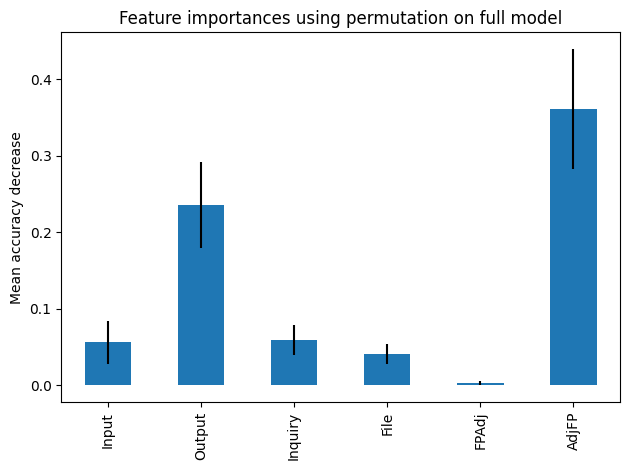

In [ ]:
# Uso de permutation importance
permu = permutation_importance(modelo_voting, x_test, y_test, n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=feature_names)[permu.importances_mean.round(3) > 0.000]
fig, ax = plt.subplots()
permu_importances.plot.bar(yerr=permu.importances_std[permu.importances_mean.round(3) > 0.000], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

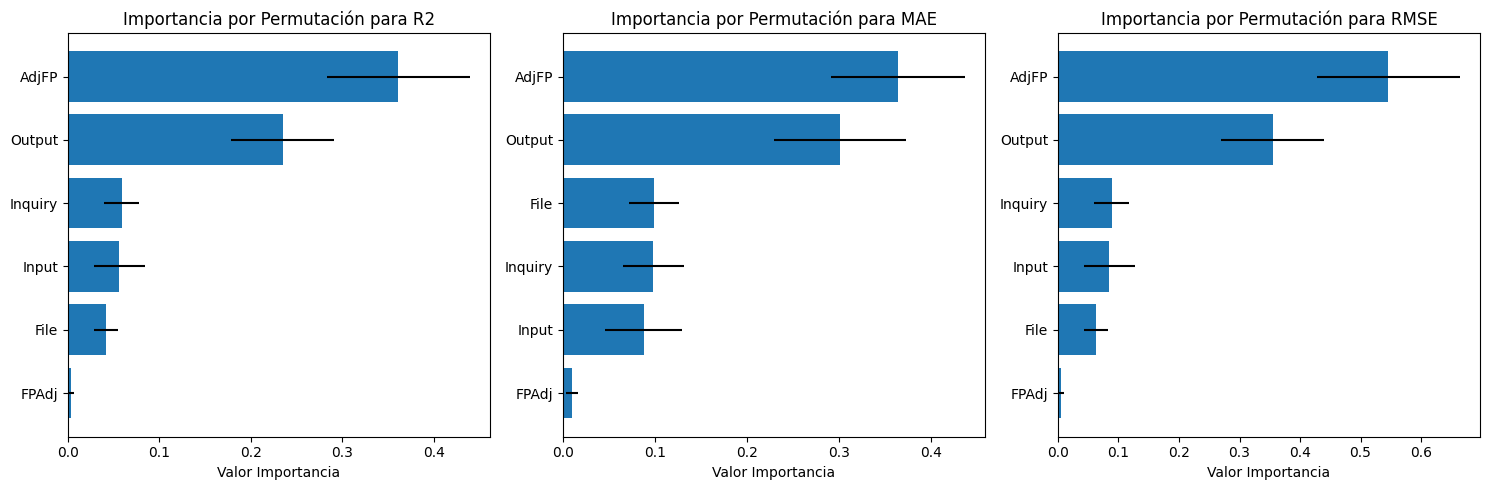

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
metric_names = ['R2', 'MAE', 'RMSE']

permu_score = permutation_importance(modelo_voting, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Itera a través de las métricas
for i, metric in enumerate(scoring):
    permu = permu_score[metric]

    # Filtra las características que cumplen la condición
    filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
    sorted_feature_names = [feature_names[j] for j in filtered_indices]
    importances_mean = permu.importances_mean[filtered_indices]
    importances_std = permu.importances_std[filtered_indices]

    # Ordena los datos por importancia de mayor a menor
    sorted_indices = np.argsort(importances_mean)[::1]
    sorted_feature_names = [sorted_feature_names[j] for j in sorted_indices]
    importances_mean = importances_mean[sorted_indices]
    importances_std = importances_std[sorted_indices]

    # Crea la representación gráfica en el subplot correspondiente
    axs[i].barh(range(len(sorted_feature_names)), importances_mean, xerr=importances_std, align='center')
    axs[i].set_yticks(range(len(sorted_feature_names)))
    axs[i].set_yticklabels(sorted_feature_names)
    axs[i].set_xlabel('Valor Importancia')
    axs[i].set_title(f'Importancia por Permutación para {metric_names[i]}')

# Ajusta los espacios entre subplots y muestra la figura
plt.tight_layout()
plt.show()

In [ ]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

# Crea un diccionario para almacenar los DataFrames
results_global_vot = {}

permu_score = permutation_importance(modelo_voting, x_test, y_test, n_repeats=20, random_state=42, scoring=scoring)
for i, metric in enumerate(scoring):
  permu = permu_score[metric]

  # Filtra las características que cumplen la condición
  filtered_indices = [j for j in range(len(permu.importances_mean)) if permu.importances_mean[j].round(3) > 0.000]
  sorted_feature_names = [feature_names[j] for j in filtered_indices]
  importances_mean = permu.importances_mean[filtered_indices]
  importances_std = permu.importances_std[filtered_indices]



  # Crear un DataFrame con los resultados
  df_exp_global = pd.DataFrame({'Feature': sorted_feature_names,
                       'Importance_Mean': importances_mean,
                       'Importance_Std': importances_std})

  # Ordenar el DataFrame por importance_mean en orden descendente
  df_exp_global = df_exp_global.sort_values(by='Importance_Mean', ascending=False)

  # Asignar el DataFrame al diccionario con el nombre de la métrica
  results_global_vot[f'df_global_{metric_names[i]}'] = df_exp_global

In [ ]:
results_global_vot['df_global_R2']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.361410,0.078208
1,Output,0.234894,0.056209
2,Inquiry,0.058927,0.019141
0,Input,0.056202,0.028137
3,File,0.041463,0.012782
4,FPAdj,0.003450,0.003019


In [ ]:
results_global_vot['df_global_MAE']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.363444,0.072933
1,Output,0.300578,0.071568
3,File,0.098773,0.026726
2,Inquiry,0.098156,0.033123
0,Input,0.087570,0.041526
4,FPAdj,0.009381,0.006617


In [ ]:
results_global_vot['df_global_RMSE']

,Feature,Importance_Mean,Importance_Std
5,AdjFP,0.546002,0.118153
1,Output,0.354868,0.084917
2,Inquiry,0.089025,0.028917
0,Input,0.084908,0.042508
3,File,0.062640,0.019311
4,FPAdj,0.005212,0.004562


**BREAK-DOWN, SHAP Y LIME:**

In [ ]:
#primero definimos el explainer
exp = dx.Explainer(modelo_voting, x_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 33 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 33 values
  -> model_class       : sklearn.ensemble._voting.VotingRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7e7270548d30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -0.715, mean = -0.248, max = 2.64
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.112, mean = 0.00564, max = 0.356
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [ ]:
#Primero obtenemos las instancias con valor estimado máximo, minimo y en la mediana.
max_index = np.argmax(y_pred)
min_index = np.argmin(y_pred)
mediana = np.median(y_pred)
#Encontrar el índice de la instancia cuyo valor estimado está en la mediana
median_index = np.argmin(np.abs(y_pred - mediana))

print("Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es: ", max_index)
print("El valor máximo obtenido es: ", y_pred[max_index])
print("Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es: ", min_index)
print("El valor mínimo obtenido es: ", y_pred[min_index])
print("Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana: ", median_index)
print("El valor de la mediana es: ", y_pred[median_index])

Índice de la instancia del conjunto de entrenamiento con mayor esfuerzo estimado es:  7
El valor máximo obtenido es:  2.6394627863946045
Ínidce de la instancia del conjunto de entrenamiento con menor esfuerzo estimado es:  10
El valor mínimo obtenido es:  -0.7147073234968558
Índice de la instancia del conjunto de entrenamiento con esfuerzo estimado en la mediana:  11
El valor de la mediana es:  -0.3513047776339063


In [ ]:
df_instancia_max = x_test.iloc[max_index]
df_instancia_median = x_test.iloc[median_index]
df_instancia_min = x_test.iloc[min_index]

In [ ]:
breakdown_max = exp.predict_parts(df_instancia_max, type="break_down",random_state=42)
breakdown_median = exp.predict_parts(df_instancia_median, type="break_down",random_state=42)
breakdown_min = exp.predict_parts(df_instancia_min, type="break_down",random_state=42)

shap_max = exp.predict_parts(df_instancia_max, type="shap",random_state=42)
shap_median = exp.predict_parts(df_instancia_median, type="shap",random_state=42)
shap_min = exp.predict_parts(df_instancia_min, type="shap",random_state=42)

lime_max = exp.predict_surrogate(df_instancia_max, random_state=42)
lime_median = exp.predict_surrogate(df_instancia_median, random_state=42)
lime_min = exp.predict_surrogate(df_instancia_min, random_state=42)

breakdown_df_max = breakdown_max.result
shap_df_max = shap_max.result
lime_df_max=lime_max.result
breakdown_df_median = breakdown_median.result
shap_df_median = shap_median.result
lime_df_median= lime_median.result
breakdown_df_min = breakdown_min.result
shap_df_min = shap_min.result
lime_df_min = lime_min.result

In [ ]:
breakdown_max.plot()
breakdown_median.plot()
breakdown_min.plot()

In [ ]:
shap_max.plot()
shap_median.plot()
shap_min.plot()

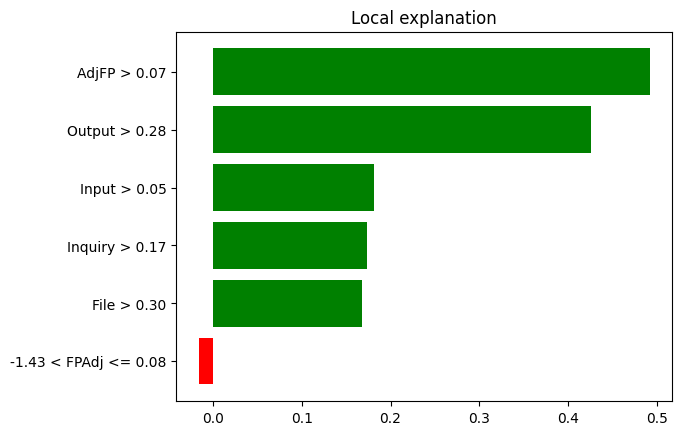

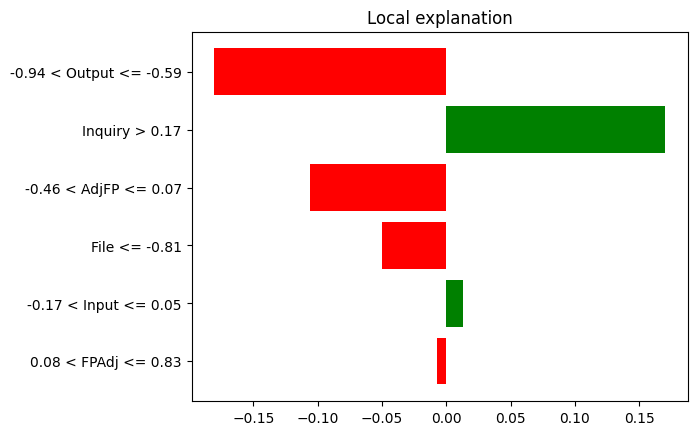

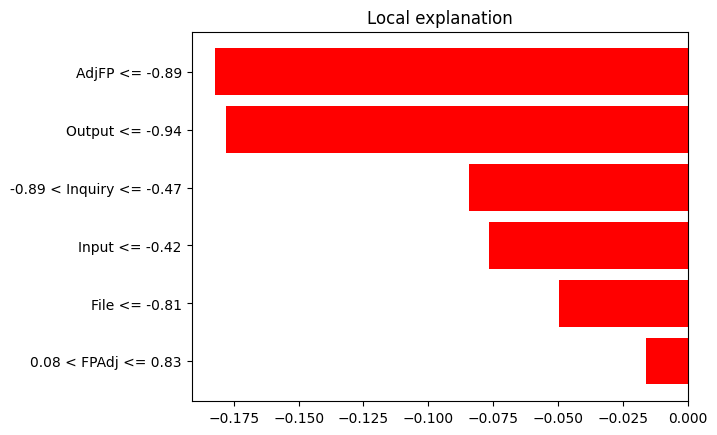

In [ ]:
lime_max.plot()
lime_median.plot()
lime_min.plot()

In [ ]:
lime_max.show_in_notebook()
lime_median.show_in_notebook()
lime_min.show_in_notebook()

### MAX:

In [ ]:
breakdown_df_max = breakdown_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_max = breakdown_df_max.drop(index=[0, 7])
breakdown_df_max['sign'] = breakdown_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_max = breakdown_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_max = shap_df_max.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_max = shap_df_max.tail(6)
shap_df_max['sign'] = shap_df_max['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_max = shap_df_max.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_max["Variable"] = lime_df_max["variable"].str.split(" ").str[0]
lime_df_max["Signo"] = lime_df_max["effect"].apply(evaluar_valor)
lime_df_max = lime_df_max.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_max = lime_df_max.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_max['Ranking'] = breakdown_df_max['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_max = breakdown_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_max['Ranking'] = shap_df_max['contribution'].abs().rank(ascending=False).astype(int)
shap_df_max.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_max = shap_df_max[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_max['Ranking'] = lime_df_max['effect'].abs().rank(ascending=False).astype(int)
lime_df_max = lime_df_max.head(5)
lime_df_max = lime_df_max[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_max = breakdown_df_max.drop(columns=['contribution'])
shap_df_max = shap_df_max.drop(columns=['contribution'])
lime_df_max = lime_df_max.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_max = breakdown_df_max.head(5)
breakdown_df_max = breakdown_df_max.reset_index(drop=True)

shap_df_max = shap_df_max.head(5)
shap_df_max = shap_df_max.reset_index(drop=True)

lime_df_max = lime_df_max.reset_index(drop=True)

print(breakdown_df_max)
print(shap_df_max)
print(lime_df_max)

  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2    Input        3  Positivo
3  Inquiry        4  Positivo
4     File        5  Positivo
  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2    Input        3  Positivo
3  Inquiry        4  Positivo
4     File        5  Positivo
  Variable  Ranking     Signo
0    AdjFP        1  Positivo
1   Output        2  Positivo
2    Input        3  Positivo
3  Inquiry        4  Positivo
4     File        5  Positivo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_max['Variable'])
shapley_features = list(shap_df_max['Variable'])
lime_features = list(lime_df_max['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_max = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_max['Variable'] = list(all_features)
df_final_max= df_final_max[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_max['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_max[breakdown_df_max['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_max[shap_df_max['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_max[lime_df_max['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_max.loc[df_final_max['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_max

['AdjFP', 'Output', 'Input', 'Inquiry', 'File']
['AdjFP', 'Output', 'Input', 'Inquiry', 'File']
['AdjFP', 'Output', 'Input', 'Inquiry', 'File']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         5  Positivo       5  Positivo       5  Positivo
1    Input         3  Positivo       3  Positivo       3  Positivo
2    AdjFP         1  Positivo       1  Positivo       1  Positivo
3   Output         2  Positivo       2  Positivo       2  Positivo
4  Inquiry         4  Positivo       4  Positivo       4  Positivo

In [ ]:
df_final_max.set_index('Variable', inplace=True)
nuevo_orden = ["AdjFP", "Output", "Input", "Inquiry", "File"]

# Reorganizar el DataFrame según el nuevo orden
df_final_max = df_final_max.reindex(nuevo_orden)

df_final_max

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
AdjFP            1  Positivo       1  Positivo       1  Positivo
Output           2  Positivo       2  Positivo       2  Positivo
Input            3  Positivo       3  Positivo       3  Positivo
Inquiry          4  Positivo       4  Positivo       4  Positivo
File             5  Positivo       5  Positivo       5  Positivo

### MEDIAN:

In [ ]:
breakdown_df_median = breakdown_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_median = breakdown_df_median.drop(index=[0, 7])
breakdown_df_median['sign'] = breakdown_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_median = breakdown_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_median = shap_df_median.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_median = shap_df_median.tail(6)
shap_df_median['sign'] = shap_df_median['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_median = shap_df_median.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_median["Variable"] = lime_df_median["variable"].str.split(" ").str[0]
lime_df_median["Signo"] = lime_df_median["effect"].apply(evaluar_valor)
lime_df_median = lime_df_median.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_median = lime_df_median.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_median['Ranking'] = breakdown_df_median['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_median = breakdown_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_median['Ranking'] = shap_df_median['contribution'].abs().rank(ascending=False).astype(int)
shap_df_median.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_median = shap_df_median[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_median['Ranking'] = lime_df_median['effect'].abs().rank(ascending=False).astype(int)
lime_df_median = lime_df_median.head(5)
lime_df_median = lime_df_median[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_median = breakdown_df_median.drop(columns=['contribution'])
shap_df_median = shap_df_median.drop(columns=['contribution'])
lime_df_median = lime_df_median.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_median = breakdown_df_median.head(5)
breakdown_df_median = breakdown_df_median.reset_index(drop=True)

shap_df_median = shap_df_median.head(5)
shap_df_median = shap_df_median.reset_index(drop=True)

lime_df_median = lime_df_median.reset_index(drop=True)
lime_df_median.at[0, "Variable"] = "Output"
lime_df_median.at[2, "Variable"] = "AdjFP"
lime_df_median.at[4, "Variable"] = "Input"

print(breakdown_df_median)
print(shap_df_median)
print(lime_df_median)

  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2  Inquiry        3  Positivo
3     File        4  Negativo
4    Input        5  Positivo
  Variable  Ranking     Signo
0   Output        1  Negativo
1  Inquiry        2  Positivo
2    AdjFP        3  Negativo
3     File        4  Negativo
4    Input        5  Positivo
  Variable  Ranking     Signo
0   Output        1  Negativo
1  Inquiry        2  Positivo
2    AdjFP        3  Negativo
3     File        4  Negativo
4    Input        5  Positivo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_median['Variable'])
shapley_features = list(shap_df_median['Variable'])
lime_features = list(lime_df_median['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_median = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_median['Variable'] = list(all_features)
df_final_median= df_final_median[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_median['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_median[breakdown_df_median['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_median[shap_df_median['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_median[lime_df_median['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_median.loc[df_final_median['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_median

['Output', 'AdjFP', 'Inquiry', 'File', 'Input']
['Output', 'Inquiry', 'AdjFP', 'File', 'Input']
['Output', 'Inquiry', 'AdjFP', 'File', 'Input']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         4  Negativo       4  Negativo       4  Negativo
1    Input         5  Positivo       5  Positivo       5  Positivo
2    AdjFP         2  Negativo       3  Negativo       3  Negativo
3   Output         1  Negativo       1  Negativo       1  Negativo
4  Inquiry         3  Positivo       2  Positivo       2  Positivo

In [ ]:
df_final_median.set_index('Variable', inplace=True)
nuevo_orden = ["Output","AdjFP", "Inquiry", "File", "Input"]

# Reorganizar el DataFrame según el nuevo orden
df_final_median = df_final_median.reindex(nuevo_orden)

df_final_median

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Output           1  Negativo       1  Negativo       1  Negativo
AdjFP            2  Negativo       3  Negativo       3  Negativo
Inquiry          3  Positivo       2  Positivo       2  Positivo
File             4  Negativo       4  Negativo       4  Negativo
Input            5  Positivo       5  Positivo       5  Positivo

### MIN:

In [ ]:
breakdown_df_min = breakdown_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
breakdown_df_min = breakdown_df_min.drop(index=[0, 7])
breakdown_df_min['sign'] = breakdown_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
breakdown_df_min = breakdown_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

shap_df_min = shap_df_min.loc[:, ['variable_name', 'contribution', 'sign']]
shap_df_min = shap_df_min.tail(6)
shap_df_min['sign'] = shap_df_min['sign'].replace({1.0: 'Positivo', 0.0: 'Nulo', -1.0: 'Negativo'})
shap_df_min = shap_df_min.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

lime_df_min["Variable"] = lime_df_min["variable"].str.split(" ").str[0]
lime_df_min["Signo"] = lime_df_min["effect"].apply(evaluar_valor)
lime_df_min = lime_df_min.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
lime_df_min = lime_df_min.drop(columns=['variable'])

# Agregar una columna de ranking
breakdown_df_min['Ranking'] = breakdown_df_min['contribution'].abs().rank(ascending=False).astype(int)
breakdown_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
breakdown_df_min = breakdown_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

shap_df_min['Ranking'] = shap_df_min['contribution'].abs().rank(ascending=False).astype(int)
shap_df_min.rename(columns={'sign': 'Signo', 'variable_name':'Variable'}, inplace=True)
shap_df_min = shap_df_min[['Variable', 'Ranking', 'contribution', 'Signo']]

lime_df_min['Ranking'] = lime_df_min['effect'].abs().rank(ascending=False).astype(int)
lime_df_min = lime_df_min.head(5)
lime_df_min = lime_df_min[['Variable', 'Ranking', 'effect', 'Signo']]

# Elimino la columna de la contribucion
breakdown_df_min = breakdown_df_min.drop(columns=['contribution'])
shap_df_min = shap_df_min.drop(columns=['contribution'])
lime_df_min = lime_df_min.drop(columns=['effect'])

# Filtrar las 5 primeras contribuciones en valor absoluto
breakdown_df_min = breakdown_df_min.head(5)
breakdown_df_min = breakdown_df_min.reset_index(drop=True)

shap_df_min = shap_df_min.head(5)
shap_df_min = shap_df_min.reset_index(drop=True)

lime_df_min = lime_df_min.reset_index(drop=True)
lime_df_min.at[2, "Variable"] = "Inquiry"

print(breakdown_df_min)
print(shap_df_min)
print(lime_df_min)

  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2  Inquiry        3  Negativo
3    Input        4  Negativo
4     File        5  Negativo
  Variable  Ranking     Signo
0   Output        1  Negativo
1    AdjFP        2  Negativo
2     File        3  Negativo
3  Inquiry        4  Negativo
4    Input        5  Negativo
  Variable  Ranking     Signo
0    AdjFP        1  Negativo
1   Output        2  Negativo
2  Inquiry        3  Negativo
3    Input        4  Negativo
4     File        5  Negativo


In [ ]:
# Obtener todas las características únicas de las tres técnicas
breakdown_features = list(breakdown_df_min['Variable'])
shapley_features = list(shap_df_min['Variable'])
lime_features = list(lime_df_min['Variable'])
all_features = list(set(breakdown_features + shapley_features + lime_features))
all_features = all_features[::-1]

df_final_min = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
df_final_min['Variable'] = list(all_features)
df_final_min= df_final_min[['Variable', 'Breakdown', 'Shapley', 'Lime']]

print(breakdown_features)
print(shapley_features)
print(lime_features)
print(all_features)

for feature in df_final_min['Variable']:
    # Buscar la característica en el DataFrame de Breakdown
    breakdown_row = breakdown_df_min[breakdown_df_min['Variable'] == feature]
    if not breakdown_row.empty:
        # Si se encuentra, obtener los valores de "Ranking" y "Signo"
        ranking_breakdown = breakdown_row.iloc[0]['Ranking']
        signo_breakdown = breakdown_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = signo_breakdown
    else:
        # Si no se encuentra, añadir "-"
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Breakdown', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Shapley
    shap_row = shap_df_min[shap_df_min['Variable'] == feature]
    if not shap_row.empty:
        ranking_shap = shap_row.iloc[0]['Ranking']
        signo_shap = shap_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = ranking_shap
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = signo_shap
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Shapley', 'Signo')] = '-'

    # Repetir el proceso para el DataFrame de Lime
    lime_row = lime_df_min[lime_df_min['Variable'] == feature]
    if not lime_row.empty:
        ranking_lime = lime_row.iloc[0]['Ranking']
        signo_lime = lime_row.iloc[0]['Signo']
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = ranking_lime
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = signo_lime
    else:
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Ranking')] = '-'
        df_final_min.loc[df_final_min['Variable'] == feature, ('Lime', 'Signo')] = '-'

df_final_min

['Output', 'AdjFP', 'Inquiry', 'Input', 'File']
['Output', 'AdjFP', 'File', 'Inquiry', 'Input']
['AdjFP', 'Output', 'Inquiry', 'Input', 'File']
['File', 'Input', 'AdjFP', 'Output', 'Inquiry']


Variable Breakdown           Shapley              Lime          
             Ranking     Signo Ranking     Signo Ranking     Signo
0     File         5  Negativo       3  Negativo       5  Negativo
1    Input         4  Negativo       5  Negativo       4  Negativo
2    AdjFP         2  Negativo       2  Negativo       1  Negativo
3   Output         1  Negativo       1  Negativo       2  Negativo
4  Inquiry         3  Negativo       4  Negativo       3  Negativo

In [ ]:
df_final_min.set_index('Variable', inplace=True)
nuevo_orden = ["Output", "AdjFP", "Inquiry", "Input", "File"]

# Reorganizar el DataFrame según el nuevo orden
df_final_min = df_final_min.reindex(nuevo_orden)

df_final_min

Breakdown           Shapley              Lime          
           Ranking     Signo Ranking     Signo Ranking     Signo
Variable                                                        
Output           1  Negativo       1  Negativo       2  Negativo
AdjFP            2  Negativo       2  Negativo       1  Negativo
Inquiry          3  Negativo       4  Negativo       3  Negativo
Input            4  Negativo       5  Negativo       4  Negativo
File             5  Negativo       3  Negativo       5  Negativo

### GLOBAL

In [ ]:
ranking_valores = {
    'Breakdown': [],
    'Shapley': [],
    'Lime': []
}

# Recorre los DataFrames y almacena los pares de valores por técnica
for tecnica in ranking_valores:
    for caracteristica in df_final_max.index:
        ranking = df_final_max[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_median.index:
        ranking = df_final_median[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

    for caracteristica in df_final_min.index:
        ranking = df_final_min[(tecnica, 'Ranking')][caracteristica]
        if ranking != "-":
            ranking_valores[tecnica].append((caracteristica, int(ranking)))

# Calcula el ranking medio por técnica y característica
ranking_medio = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, ranking in ranking_values:
        if caracteristica not in ranking_medio[tecnica]:
            ranking_medio[tecnica][caracteristica] = [ranking]
        else:
            ranking_medio[tecnica][caracteristica].append(ranking)

for tecnica, ranking_values in ranking_medio.items():
    for caracteristica in ranking_values:
        ranking_medio[tecnica][caracteristica] = sum(ranking_values[caracteristica]) / len(ranking_values[caracteristica])


# Ahora el conteo de apariciones por característica y técnica
apariciones_count = {
    'Breakdown': {},
    'Shapley': {},
    'Lime': {}
}

for tecnica, ranking_values in ranking_valores.items():
    for caracteristica, _ in ranking_values:
        if caracteristica not in apariciones_count[tecnica]:
            apariciones_count[tecnica][caracteristica] = 1
        else:
            apariciones_count[tecnica][caracteristica] += 1

# Tengo los valores, los conteos de apariciones y los ranking medios por técnica en los respectivos diccionarios
print(ranking_valores)
print(apariciones_count)
print(ranking_medio)

{'Breakdown': [('AdjFP', 1), ('Output', 2), ('Input', 3), ('Inquiry', 4), ('File', 5), ('Output', 1), ('AdjFP', 2), ('Inquiry', 3), ('File', 4), ('Input', 5), ('Output', 1), ('AdjFP', 2), ('Inquiry', 3), ('Input', 4), ('File', 5)], 'Shapley': [('AdjFP', 1), ('Output', 2), ('Input', 3), ('Inquiry', 4), ('File', 5), ('Output', 1), ('AdjFP', 3), ('Inquiry', 2), ('File', 4), ('Input', 5), ('Output', 1), ('AdjFP', 2), ('Inquiry', 4), ('Input', 5), ('File', 3)], 'Lime': [('AdjFP', 1), ('Output', 2), ('Input', 3), ('Inquiry', 4), ('File', 5), ('Output', 1), ('AdjFP', 3), ('Inquiry', 2), ('File', 4), ('Input', 5), ('Output', 2), ('AdjFP', 1), ('Inquiry', 3), ('Input', 4), ('File', 5)]}
{'Breakdown': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'Inquiry': 3, 'File': 3}, 'Shapley': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'Inquiry': 3, 'File': 3}, 'Lime': {'AdjFP': 3, 'Output': 3, 'Input': 3, 'Inquiry': 3, 'File': 3}}
{'Breakdown': {'AdjFP': 1.6666666666666667, 'Output': 1.3333333333333333, 'Input': 4.0, 

In [ ]:
# Lista de técnicas
techniques = ['Breakdown', 'Shapley', 'Lime']

# Diccionario para almacenar los datos
data_dict = {}

# Crear una lista de todas las características
all_caract = list(set().union(*[set(ranking_medio[technique]) for technique in techniques]))

# Recorrer las técnicas y las características
for technique in techniques:
    caract = list(ranking_medio[technique].keys())
    rank = [ranking_medio[technique].get(c, "-") for c in all_caract]
    apar = [apariciones_count[technique].get(c, "-") for c in all_caract]

    # Agregar los datos al diccionario
    data_dict[(technique, "Ranking Medio")] = rank
    data_dict[(technique, "Conteo")] = apar

# Crear el DataFrame resumen
df_resumen_vot = pd.DataFrame(data_dict, index=all_caract)

df_resumen_vot

Breakdown              Shapley                 Lime       
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo
Inquiry      3.333333      3      3.333333      3      3.000000      3
Output       1.333333      3      1.333333      3      1.666667      3
AdjFP        1.666667      3      2.000000      3      1.666667      3
Input        4.000000      3      4.333333      3      4.000000      3
File         4.666667      3      4.000000      3      4.666667      3

In [ ]:
# Calcular el ranking medio general omitiendo los valores "-"
df_resumen_vot[("General", "Ranking")] = df_resumen_vot[[(tech, "Ranking Medio") for tech in techniques]].replace('-', np.nan).mean(axis=1)

# Calcular la suma total de apariciones omitiendo los valores "-"
df_resumen_vot[("General", "Conteo Total")] = df_resumen_vot[[(tech, "Conteo") for tech in techniques]].replace('-', 0).sum(axis=1)

# Mostrar el DataFrame resumen actualizado
df_resumen_vot

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry      3.333333      3      3.333333      3      3.000000      3   
Output       1.333333      3      1.333333      3      1.666667      3   
AdjFP        1.666667      3      2.000000      3      1.666667      3   
Input        4.000000      3      4.333333      3      4.000000      3   
File         4.666667      3      4.000000      3      4.666667      3   

          General               
          Ranking Conteo Total  
Inquiry  3.222222            9  
Output   1.444444            9  
AdjFP    1.777778            9  
Input    4.111111            9  
File     4.444444            9

In [ ]:
# Obtener el número de características
num_caract = df_resumen_vot.shape[0]

# Calcular el peso para el ranking y apariciones
df_resumen_vot[("General", "Peso Rango")] = 1 - ((df_resumen_vot[("General", "Ranking")].rank(ascending=True) - 1) / num_caract)
df_resumen_vot[("General", "Peso Conteo")] = df_resumen_vot[("General", "Conteo Total")].rank(ascending=True) / num_caract

# Calcular el puntaje final como suma de los pesos
df_resumen_vot[("General", "Puntaje")] = df_resumen_vot[("General", "Peso Rango")] + df_resumen_vot[("General", "Peso Conteo")]
df_resumen_vot[("General", "Ranking")] = df_resumen_vot[("General", "Puntaje")].rank(ascending=False, method="min")

# Eliminar la subcolumnas innecesarias
df_resumen_vot.drop("Peso Rango", axis=1, level=1, inplace=True)
df_resumen_vot.drop("Peso Conteo", axis=1, level=1, inplace=True)
df_resumen_vot.drop("Puntaje", axis=1, level=1, inplace=True)

df_resumen_vot

Breakdown              Shapley                 Lime         \
        Ranking Medio Conteo Ranking Medio Conteo Ranking Medio Conteo   
Inquiry      3.333333      3      3.333333      3      3.000000      3   
Output       1.333333      3      1.333333      3      1.666667      3   
AdjFP        1.666667      3      2.000000      3      1.666667      3   
Input        4.000000      3      4.333333      3      4.000000      3   
File         4.666667      3      4.000000      3      4.666667      3   

        General               
        Ranking Conteo Total  
Inquiry     3.0            9  
Output      1.0            9  
AdjFP       2.0            9  
Input       4.0            9  
File        5.0            9

In [ ]:
# Obtener las columnas actuales del DataFrame
columns = df_resumen_vot.columns

# Extraer las columnas de "General" y sus subcolumnas
general_columns = columns.get_level_values(0) == "General"

# Crear una lista con las subcolumnas de "General"
general_subcolumns = [("General", "Ranking"), ("General", "Conteo Total")]

# Crear una lista con las subcolumnas asociadas a las técnicas
technique_subcolumns = list(columns[~general_columns])

# Reorganizar las columnas para mover "General" al principio
new_columns = general_subcolumns + technique_subcolumns

# Crear un nuevo DataFrame con las columnas reorganizadas
df_resumen_vot = df_resumen_vot[new_columns]

In [ ]:
df_resumen_vot.sort_values(by=("General", "Ranking"), ascending=True, inplace=True)

# Formatear los valores
for tech in techniques:
    df_resumen_vot[(tech, "Ranking Medio")] = df_resumen_vot[(tech, "Ranking Medio")].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

df_resumen_vot

General                  Breakdown              Shapley         \
        Ranking Conteo Total Ranking Medio Conteo Ranking Medio Conteo   
Output      1.0            9          1.33      3          1.33      3   
AdjFP       2.0            9          1.67      3          2.00      3   
Inquiry     3.0            9          3.33      3          3.33      3   
Input       4.0            9          4.00      3          4.33      3   
File        5.0            9          4.67      3          4.00      3   

                 Lime         
        Ranking Medio Conteo  
Output           1.67      3  
AdjFP            1.67      3  
Inquiry          3.00      3  
Input            4.00      3  
File             4.67      3

## Local Datasets

In [ ]:
# Lista de DataFrames resumen y algoritmo
dfs_resumen = [df_resumen_svr, df_resumen_rf, df_resumen_gbr, df_resumen_vot]
algorithms = ['SVR', 'RF', 'GBR', 'VOT']

# Crear un conjunto de índices único
index_set = set()

# Iterar sobre cada DataFrame resumen y agregar sus índices al conjunto
for df_resumen in dfs_resumen:
    index_set.update(df_resumen.index)
index_list = list(index_set)

# Crear un nuevo DataFrame para el resultado final
df_resumen_final = pd.DataFrame(index=index_list)

# Agregar las columnas de "General" con "Ranking" y "Conteo Total" para cada algoritmo
for algorithm, df_resumen in zip(algorithms, dfs_resumen):
    df_resumen_final[(algorithm, 'Ranking')] = df_resumen[('General', 'Ranking')]
    df_resumen_final[(algorithm, 'Conteo Total')] = df_resumen[('General', 'Conteo Total')]

# Rellenar el DataFrame final con datos o '-'
df_resumen_final = df_resumen_final.fillna('-')

# Calcular el ranking final promediando los rankings de las técnicas
df_resumen_final["Ranking Final"] = df_resumen_final[[(algo, "Ranking") for algo in algorithms]].replace('-', np.nan).mean(axis=1)

# Calcular la suma total de apariciones omitiendo los valores "-"
df_resumen_final[("Conteo Final")] = df_resumen_final[[(algo, "Conteo Total") for algo in algorithms]].replace('-', 0).sum(axis=1)

# Obtener el número de características
num_caract = df_resumen_final.shape[0]

# Calcular el peso para el ranking y apariciones
df_resumen_final[("Peso Rango")] = 1 - ((df_resumen_final[("Ranking Final")].rank(ascending=True) - 1) / num_caract)
df_resumen_final[("Peso Conteo")] = df_resumen_final[("Conteo Final")].rank(ascending=True) / num_caract

# Calcular el puntaje final como suma de los pesos
df_resumen_final[("Puntaje")] = df_resumen_final[("Peso Rango")] + df_resumen_final[("Peso Conteo")]
df_resumen_final[("Ranking Final")] = df_resumen_final[("Puntaje")].rank(ascending=False, method="min")


# Eliminar las columnas innecesarias
df_resumen_final.drop("Peso Rango", axis=1, inplace=True)
df_resumen_final.drop("Peso Conteo", axis=1, inplace=True)
df_resumen_final.drop("Puntaje", axis=1, inplace=True)

df_resumen_final.sort_values(by=("Ranking Final"), ascending=True, inplace=True)

# Formatear los valores
for algo in algorithms:
    df_resumen_final[(algo, "Ranking")] = df_resumen_final[(algo, "Ranking")].apply(lambda x: f"{x:.0f}" if isinstance(x, (int, float)) else x)
    df_resumen_final[(algo, "Conteo Total")] = df_resumen_final[(algo, "Conteo Total")].apply(lambda x: f"{x:.0f}" if isinstance(x, (int, float)) else x)

df_resumen_final[("Ranking Final")] = df_resumen_final[("Ranking Final")].apply(lambda x: f"{x:.0f}" if isinstance(x, (int, float)) else x)
df_resumen_final[("Conteo Final")] = df_resumen_final[("Conteo Final")].apply(lambda x: f"{x:.0f}" if isinstance(x, (int, float)) else x)

df_resumen_final

,"(SVR, Ranking)","(SVR, Conteo Total)","(RF, Ranking)","(RF, Conteo Total)","(GBR, Ranking)","(GBR, Conteo Total)","(VOT, Ranking)","(VOT, Conteo Total)",Ranking Final,Conteo Final
Output,1,9,2,9,1,9,1,9,1,36
AdjFP,3,9,1,9,2,9,2,9,2,36
Inquiry,2,9,5,8,4,9,3,9,3,35
File,5,9,4,9,5,8,5,9,4,35
Input,4,6,3,9,3,9,4,9,5,33
FPAdj,6,3,6,1,6,1,-,-,6,5


In [ ]:
# Lista de DataFrames resumen y algoritmo
dfs_resumen = [df_resumen_svr, df_resumen_rf, df_resumen_gbr, df_resumen_vot]
algorithms = ['SVR', 'RF', 'GBR', 'VOT']

# Crear un conjunto de índices único
index_set = set()

# Iterar sobre cada DataFrame resumen y agregar sus índices al conjunto
for df_resumen in dfs_resumen:
    index_set.update(df_resumen.index)

index_list = list(index_set)

# Crear un nuevo DataFrame para el resultado final con los índices únicos
df_resumen_final = pd.DataFrame(index=index_list)

# Agregar las columnas de "General" con "Ranking" y "Conteo Total" para cada algoritmo
for algorithm, df_resumen in zip(algorithms, dfs_resumen):
    df_resumen_final[(algorithm, 'Ranking')] = df_resumen[('General', 'Ranking')]
    df_resumen_final[(algorithm, 'Conteo Total')] = df_resumen[('General', 'Conteo Total')]

# Rellenar el DataFrame final con datos o '-'
df_resumen_final = df_resumen_final.fillna('-')

# Calcular el ranking final promediando los rankings de las técnicas
df_resumen_final["Ranking Final"] = df_resumen_final[[(algo, "Ranking") for algo in algorithms]].replace('-', np.nan).mean(axis=1)

# Calcular la suma total de apariciones omitiendo los valores "-"
df_resumen_final["Conteo Final"] = df_resumen_final[[(algo, "Conteo Total") for algo in algorithms]].replace('-', 0).sum(axis=1)

# Obtener el número de características
num_caract = df_resumen_final.shape[0]

# Calcular el peso para el ranking y apariciones
df_resumen_final[("Peso Rango")] = 1 - ((df_resumen_final[("Ranking Final")].rank(ascending=True) - 1) / num_caract)
df_resumen_final[("Peso Conteo")] = df_resumen_final[("Conteo Final")].rank(ascending=True) / num_caract

# Calcular el puntaje final como suma de los pesos
df_resumen_final[("Puntaje")] = df_resumen_final[("Peso Rango")] + df_resumen_final[("Peso Conteo")]
df_resumen_final[("Ranking Final")] = df_resumen_final[("Puntaje")].rank(ascending=False, method="min")

# Eliminar las subcolumnas innecesarias
df_resumen_final.drop("Peso Rango", axis=1, inplace=True)
df_resumen_final.drop("Peso Conteo", axis=1, inplace=True)
df_resumen_final.drop("Puntaje", axis=1, inplace=True)

df_resumen_final.sort_values(by=("Ranking Final"), ascending=True, inplace=True)

df_resumen_final

,"(SVR, Ranking)","(SVR, Conteo Total)","(RF, Ranking)","(RF, Conteo Total)","(GBR, Ranking)","(GBR, Conteo Total)","(VOT, Ranking)","(VOT, Conteo Total)",Ranking Final,Conteo Final
Output,1.0,9,2.0,9,1.0,9,1.0,9.0,1.0,36.0
AdjFP,3.0,9,1.0,9,2.0,9,2.0,9.0,2.0,36.0
Inquiry,2.0,9,5.0,8,4.0,9,3.0,9.0,3.0,35.0
File,5.0,9,4.0,9,5.0,8,5.0,9.0,4.0,35.0
Input,4.0,6,3.0,9,3.0,9,4.0,9.0,5.0,33.0
FPAdj,6.0,3,6.0,1,6.0,1,-,-,6.0,5.0


# Resultados:

In [ ]:
score_result=score_result.drop("MSE",axis=1)

In [ ]:
score_result

,Modelo,MAE,RMSE,R2,MMRE,PRED(0.25)
0,SVR,0.138860,0.212018,0.898506,0.165299,0.957778
1,RandomForest,0.125062,0.223664,0.862231,0.113977,0.937778
2,GradientBoosting,0.072432,0.159657,0.888886,0.057860,0.957778
3,Voting,0.104079,0.185210,0.895158,0.092847,0.957778


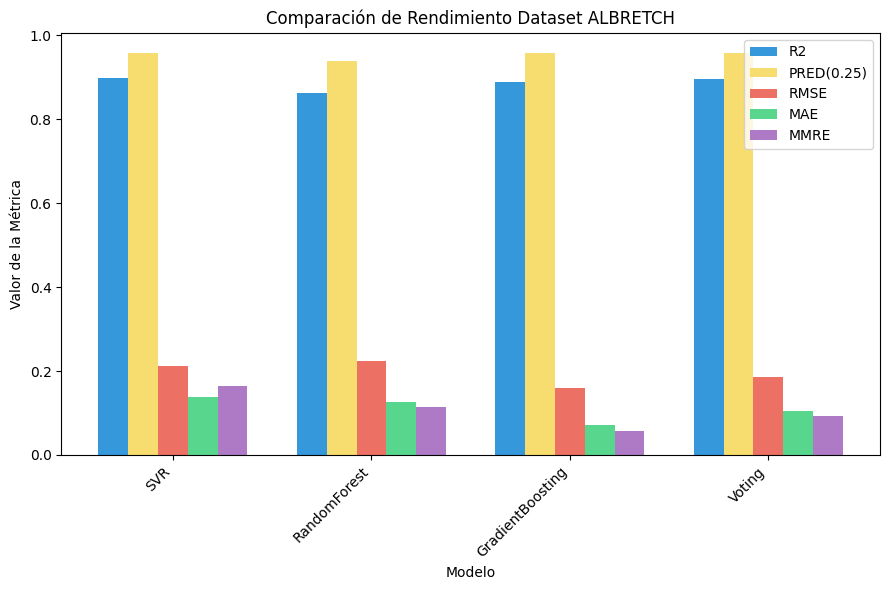

In [ ]:
metricas = ['R2', 'PRED(0.25)', 'RMSE', 'MAE', 'MMRE']
colores = ['#3498DB', '#F7DC6F','#EC7063', '#58D68D', '#AF7AC5']

num_modelos = len(score_result)
ancho_barra = 0.15
x = range(num_modelos)

plt.figure(figsize=(9, 6))

# Crear un gráfico de barras para cada métrica
for i, metrica in enumerate(metricas):
    # Calcular la posición para las barras de esta métrica
    posiciones_x = [pos + i * ancho_barra for pos in x]

    # Obtener los valores de la métrica actual
    valores_metrica = score_result[metrica]

    # Crear las barras para la métrica actual
    plt.bar(
        posiciones_x,
        valores_metrica,
        width=ancho_barra,
        label=metrica,
        color=colores[i],
    )

# Personalizar el gráfico
plt.xlabel('Modelo')
plt.ylabel('Valor de la Métrica')
plt.title('Comparación de Rendimiento Dataset ALBRETCH')
plt.xticks([pos + (len(metricas) - 1) * ancho_barra / 2 for pos in x], score_result['Modelo'], rotation=45, ha="right")
plt.legend(loc='upper right')

# Mostrar el gráfico combinado
plt.tight_layout()
plt.show()

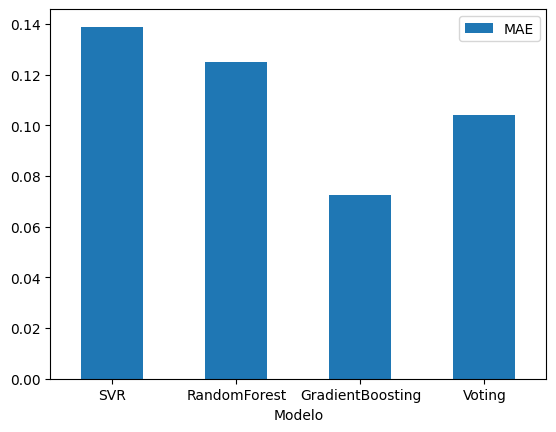

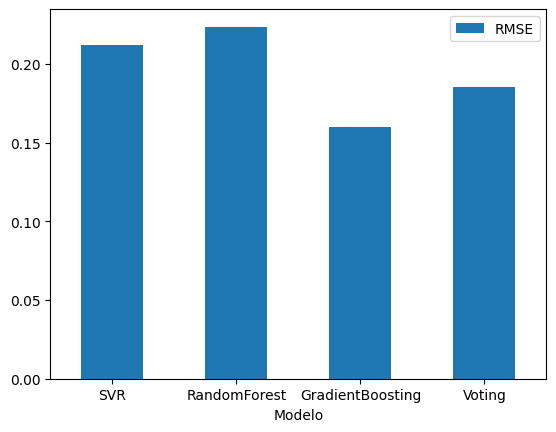

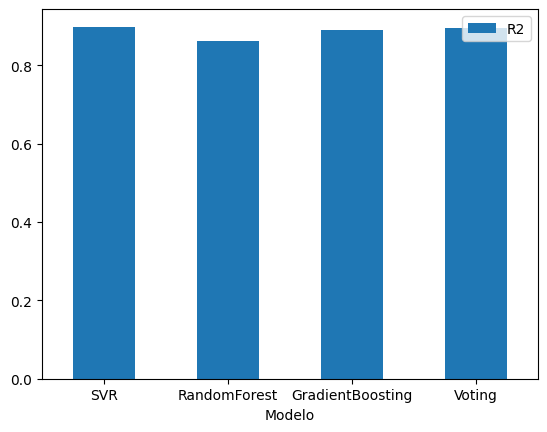

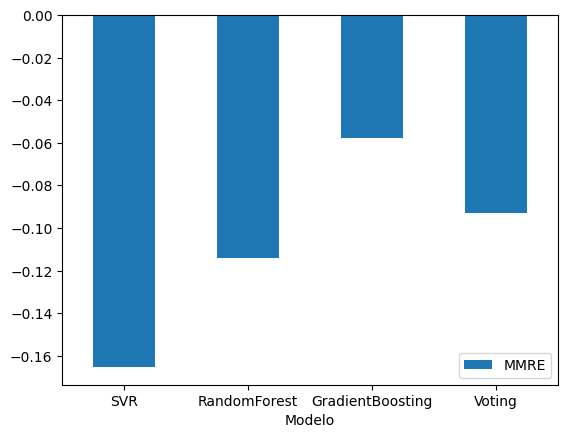

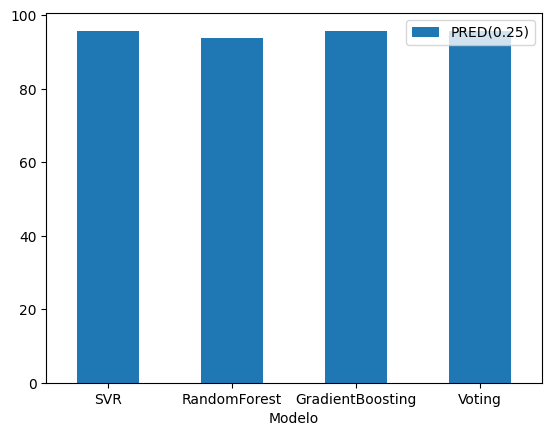

In [ ]:
variables=list(score_result)
variables.pop(0)

for var in variables:
  score_result.plot.bar(x='Modelo', y=var, rot=0)